Initial run for Isabel's Data
=================

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import pylab as plt
from IPython.display import display
import math

from lda_for_fragments import Ms2Lda

<h2>Analysis</h2>

<h3>a. Run LDA</h3>

In [2]:
fragment_filename = 'isabelpos_fragments.csv'
neutral_loss_filename = 'isabelpos_losses.csv'
mzdiff_filename = None
ms1_filename = 'isabelpos_ms1.csv'
ms2_filename = 'isabelpos_ms2.csv'
ms2lda = Ms2Lda.lcms_data_from_R(fragment_filename, neutral_loss_filename, mzdiff_filename, 
                             ms1_filename, ms2_filename)

Loading input files
Data shape (435, 1108)


In [3]:
### all the parameters you need to specify to run LDA ###

n_topics = 100
n_samples = 1000
n_burn = 0 # if 0 then we only use the last sample
n_thin = 1 # every n-th sample to use for averaging after burn-in. Ignored if n_burn = 0
alpha = 50.0/n_topics # hyper-parameter for document-topic distributions
beta = 0.1 # hyper-parameter for topic-word distributions

ms2lda.run_lda(n_topics, n_samples, n_burn, n_thin, alpha, beta)

Fitting model...
CGS LDA initialising
............................................
Using Numba for LDA sampling
Preparing words
Preparing Z matrix
DONE
Sample 1   Log likelihood = -1461466.853 
Sample 2   Log likelihood = -1042352.717 
Sample 3   Log likelihood = -728233.192 
Sample 4   Log likelihood = -615263.063 
Sample 5   Log likelihood = -575765.339 
Sample 6   Log likelihood = -556139.565 
Sample 7   Log likelihood = -544430.841 
Sample 8   Log likelihood = -534607.046 
Sample 9   Log likelihood = -528740.628 
Sample 10   Log likelihood = -522917.197 
Sample 11   Log likelihood = -518421.127 
Sample 12   Log likelihood = -515177.828 
Sample 13   Log likelihood = -513795.819 
Sample 14   Log likelihood = -512253.379 
Sample 15   Log likelihood = -509922.274 
Sample 16   Log likelihood = -507959.845 
Sample 17   Log likelihood = -506629.517 
Sample 18   Log likelihood = -505258.369 
Sample 19   Log likelihood = -503907.724 
Sample 20   Log likelihood = -502951.820 
Sample 21   Log

<h3>b. Annotations</h3>

In [4]:
sirius_platform = 'orbitrap'
ms2lda.annotate_with_sirius(sirius_platform, mode='pos', max_ms1=9999) # mode is either 'pos' or 'neg'

Running SIRIUS annotation with parameters:
- platform = orbitrap
- mode = pos
- ppm_max = 5
- min_score = 0.01
- max_ms1 = 9999

    1/  435 pID  452 m/z 385.18096 int 8.1252e+05 n_frags  5	ACCEPT	3 fragment(s) annotated with score 12.63
    2/  435 pID  631 m/z 513.25313 int 8.3645e+05 n_frags  1	ACCEPT	0 fragment(s) annotated with score 0.20
    3/  435 pID  672 m/z 358.25877 int 6.2059e+05 n_frags  9	ACCEPT	6 fragment(s) annotated with score 21.38
    4/  435 pID  693 m/z 391.25098 int 7.0632e+05 n_frags 13	ACCEPT	10 fragment(s) annotated with score 21.22
    5/  435 pID  701 m/z 763.38784 int 3.0677e+06 n_frags  5	ACCEPT	4 fragment(s) annotated with score 1.63
    6/  435 pID  716 m/z 742.45888 int 1.7964e+06 n_frags  7	ACCEPT	5 fragment(s) annotated with score 9.68
    7/  435 pID  718 m/z 880.59025 int 8.6466e+05 n_frags  5	ACCEPT	5 fragment(s) annotated with score 2.88
    8/  435 pID  723 m/z 312.21684 int 7.1932e+05 n_frags 16	ACCEPT	14 fragment(s) annotated with score 50.33
 

In [24]:
ms2lda = Ms2Lda.resume_from('isabel.project')

ERROR! Session/line number was not unique in database. History logging moved to new session 99
Project loaded from isabel.project time taken = 5.44622397423
 - input_filenames = 
	isabelpos_fragments.csv
	isabelpos_losses.csv
	isabelpos_ms1.csv
	isabelpos_ms2.csv
 - df.shape = (435, 1108)
 - K = 100
 - alpha = 0.5
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = Thu Oct  8 18:19:16 2015
 - message = Initial run on Isabel data by Joe


In [25]:
proton_mass = 1.00727645199076

# peaklist_filename = 'peaklist_POS.csv'
peaklist_filename = 'sanitized_ideom_output.csv'
peaklist = pd.read_csv(peaklist_filename)
annot = peaklist[['mz', 'rt', 'int', 'metabolite','AN3057']]
# annot = annot[pd.notnull(annot['Metabolite'])] # drop NaN metabolites


label_len = 20
mass_tol = 10
rt_tol = 5*60

# for each row in the IDIOM annotation results 
total_match = 0
for row in annot.itertuples():
    
    # get mz, rt, intensity and the putative metabolite identity
    mz = row[1] + proton_mass
    rt = row[2]
    intensity = row[3]
    label = row[4]
    fold_change = row[5]
    print fold_change
    
    # truncate long metabolite names
#     label = (label[:label_len] + '..') if len(label) > label_len else label    
    print "Processing " + str((mz, rt, intensity)) + " " + str(label)

    # find matching MS1 within mass_tol and rt_tol
    interval = mz*mass_tol*1e-6
    mass_start, mass_end = (mz-interval, mz+interval)
    rt_start, rt_end = (rt-rt_tol, rt+rt_tol)
    
    match_mass = (ms2lda.ms1.mz>mass_start) & (ms2lda.ms1.mz<mass_end)
    match_rt = (ms2lda.ms1.rt>rt_start) & (ms2lda.ms1.rt<rt_end)
    match = match_mass & match_rt
    
    res = ms2lda.ms1[match]
    if len(res) == 1:

        # if only 1 match, immediately annotate
        print "Found 1 hit"
        idx = res.index[0]
        ms2lda.ms1.loc[[idx], 'annotation'] = label
        ms2lda.ms1.loc[[idx], 'fold_change'] = fold_change
        display(res)
        total_match += 1

    elif len(res) > 0:

        print "Found %d hits" % len(res)        
        
        # if multiple matches, find the closest in RT   
        closest = None
        min_dist = sys.maxint
        for match_res in res.itertuples():
            match_rt = match_res[4]
            match_mz = match_res[5]
            dist = math.sqrt((match_rt-rt)**2 + (match_mz-mz)**2)
            if dist < min_dist:
                min_dist = dist
                closest = match_res

        idx = closest[0]
        ms2lda.ms1.loc[[idx], 'annotation'] = label
        ms2lda.ms1.loc[[idx], 'fold_change'] = fold_change
        display(res)
        total_match += 1        
        
    print
    
print "total_match=" + str(total_match) + "/" + str(annot.shape[0])

1.482959336
Processing (71.085536421990767, 232.57195980000003, 34996) nan

0.863648405
Processing (74.023649131990766, 695.99287670000012, 3532) Iminoglycine

1.668358028
Processing (74.060028581990764, 595.91434649999997, 48715) Aminoacetone
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3888,3888,0,1,508.189,74.060018,1482000.625,1,20,0,C3H7NO
5502,5502,0,1,615.361,74.060035,4867594.000,1,0,0,Aminoacetone



0.863951282
Processing (76.039059521990765, 1356.103124, 29573) nan

0.812166902
Processing (76.039295691990759, 822.14852840000003, 245819) Glycine

1.152930833
Processing (76.075680391990758, 648.14350860000002, 57397) (R)-1-Aminopropan-2-ol

1.012631981
Processing (77.008135031990761, 1380.0902100000001, 22659) nan

0.891934301
Processing (77.023065081990765, 410.51318800000001, 757550) nan

0.942447857
Processing (77.649609521990769, 257.633667, 2485) nan

3.180295842
Processing (78.099681331990766, 256.86133239999998, 6149) nan

0.926261816
Processing (78.211064611990764, 253.77637510000002, 14225) nan

0.994963144
Processing (78.984402421990765, 1287.2287550000001, 8819) nan

0.755687688
Processing (79.021203161990769, 408.629795, 130333) nan

0.812627845
Processing (79.021206391990759, 5.9989650879999994, 109253) nan

0.947069883
Processing (80.933275081990757, 717.23124689999997, 42302) Br-

0.499881122
Processing (80.947727751990755, 721.29287470000008, 16973) nan

0.77309146

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3606,3606,0,1,536.499,86.096339,15411655,1,0,0,C5H11N,NaN
3607,3607,0,1,521.822,86.096340,11351523,1,77,0,C5H11N,NaN



0.597283755
Processing (87.043988721990758, 655.28750100000002, 4522) 2-Butenoate

1.122427753
Processing (87.044030321990761, 794.88474659999997, 56969) Diacetyl

1.018365016
Processing (87.091696071990768, 1231.804695, 166322) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6470,6470,0,1,1051.8,87.091676,4503146.5,1,0,0,C4H10N2,NaN



1.418065743
Processing (87.10241521199076, 644.7585004, 3004) nan

1.023331088
Processing (88.039292101990767, 801.01649860000009, 15314) 2-Aminoacrylate

0.516191923
Processing (89.023254561990768, 462.82610319999998, 2810079) Pyruvate

1.068447619
Processing (89.023315021990769, 784.43687179999995, 352474) 3-Oxopropanoate

1.031052712
Processing (90.018562751990757, 729.32312390000004, 13831) Oxamate

0.649730571
Processing (90.054894181990761, 791.51574579999999, 10722286) L-Alanine

0.495358583
Processing (90.054958671990761, 1336.0123390000001, 391083) Sarcosine

0.31837299
Processing (90.054959461990762, 1162.7030600000001, 185944) Sarcosine

1.095888835
Processing (90.054974261990765, 1243.8015809999999, 450100) D-Alanine

0.885172658
Processing (91.038926191990768, 566.03160730000002, 1407841) (R)-Lactate

1.011229711
Processing (91.038978981990766, 1350.07313, 137345) (S)-Lactate

0.919159721
Processing (92.985879541990755, 748.762249, 23587) nan

1.021955673
Processing (93.0

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6524,6524,0,1,557.198,104.070585,19199306,1,0,0,C4H9NO2,NaN
6525,6525,0,1,646.690,104.070598,11221028,1,0,0,4-Aminobutanoate,NaN
6526,6526,0,1,478.802,104.070616,9719519,1,0,0,C4H9NO2,NaN



1.287001515
Processing (104.10688495199076, 1155.3761259999999, 28949832) Choline
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5458,5458,0,1,967.679,104.106825,1742656512,1,0,0,C5H13NO,NaN
6531,6531,0,1,981.617,104.106799,1805004032,1,0,0,C5H13NO,NaN



0.895185322
Processing (105.00044105199076, 225.79716299999998, 6931) nan

1.489512077
Processing (105.01823585199077, 798.06350199999997, 9988) 2-Hydroxy-3-oxopropanoate

0.923670765
Processing (105.02951435199077, 642.83687459999999, 35344) Urea-1-carboxylate

0.692868149
Processing (105.05460145199076, 452.55541360000001, 5750) (R)-3-Hydroxybutanoate

4.568733413
Processing (105.35036495199077, 279.13177139999999, 2474) nan

0.638538103
Processing (106.01350945199077, 757.83637239999996, 3998) nan

0.651834115
Processing (106.04984535199077, 820.65875240000003, 1305799) L-Serine

1.07057286
Processing (106.08618645199077, 653.40012279999996, 3484) Diethanolamine

0.94212072
Processing (107.01462645199076, 1313.1862640000002, 12007) nan

1.341134331
Processing (107.01462725199076, 1158.5352150000001, 22408) nan

0.355999552
Processing (107.03381265199076, 809.78719120000005, 11242) L-Glycericacid

0.431786716
Processing (107.03390115199076, 663.72237400000006, 268965) D-Glycerate

0

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3584,3584,0,1,496.476,114.066183,375707808,1,247,0,Creatinine,NaN



0.727291383
Processing (114.73356595199077, 720.97424699999999, 4310) nan

0.705262388
Processing (114.84262395199077, 720.65380449999998, 5214) nan

0.54114222
Processing (114.93338925199076, 721.25967489999994, 5050) nan

0.546960985
Processing (114.97483685199077, 721.43945680000002, 4597) nan

1.00626214
Processing (115.01394345199076, 726.24999870000011, 8904) parabanate

1.052082709
Processing (115.03897405199076, 794.34724679999999, 508504) 2-Hydroxy-2,4-pentadienoate

0.643604084
Processing (115.05023975199076, 476.2537289, 11747) 5,6-Dihydrouracil

0.636606724
Processing (116.03424305199076, 434.65248169999995, 38202) Maleamate

0.742122491
Processing (116.07038145199077, 721.79277569999999, 35457812) L-Proline
Found 9 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6579,6579,0,1,579.945,116.070491,2147066112,1,0,0,C5H9NO2,NaN
6580,6580,0,1,900.490,116.070610,14116196,1,0,0,3-acetamidopropanal,NaN
6581,6581,0,1,675.195,116.070605,42657660,1,0,0,C5H9NO2,NaN
6582,6582,0,1,799.523,116.070604,20779760,1,0,0,C5H9NO2,NaN
6583,6583,0,1,645.711,116.070626,52252268,1,0,0,C5H9NO2,NaN
6584,6584,0,1,619.300,116.070634,72310528,1,269,0,C5H9NO2,NaN
6585,6585,0,1,745.862,116.070609,20780818,1,0,0,C5H9NO2,NaN
6586,6586,0,1,713.896,116.070599,26674006,1,0,0,C5H9NO2,NaN
6587,6587,0,1,727.950,116.070602,23084028,1,265,0,L-Proline,NaN



0.821244262
Processing (116.07063315199076, 1224.182086, 62654) D-Proline

0.889230037
Processing (116.07064585199078, 1365.0393750000001, 66221) D-Proline

0.0
Processing (116.07066205199075, 966.77351639999995, 19938) 3-acetamidopropanal
Found 6 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6580,6580,0,1,900.490,116.070610,14116196,1,0,0,3-acetamidopropanal,NaN
6581,6581,0,1,675.195,116.070605,42657660,1,0,0,C5H9NO2,NaN
6582,6582,0,1,799.523,116.070604,20779760,1,0,0,C5H9NO2,NaN
6585,6585,0,1,745.862,116.070609,20780818,1,0,0,C5H9NO2,NaN
6586,6586,0,1,713.896,116.070599,26674006,1,0,0,C5H9NO2,NaN
6587,6587,0,1,727.950,116.070602,23084028,1,265,0,L-Proline,0.742122



1.514302494
Processing (116.10689675199076, 1169.743271, 9144) Trimethylaminoacetone

0.642072858
Processing (117.05462725199075, 292.13012569999995, 381491) ethylpyruvate

1.197475831
Processing (117.05464575199076, 453.41699789999996, 66694) 3-Methyl-2-oxobutanoic acid

0.836281777
Processing (117.09098725199077, 280.76697730000001, 117499) 4-Hydroxyhexan-3-one

0.928183136
Processing (118.04987205199076, 727.3482512999999, 29622) L-2-Amino-3-oxobutanoic acid

0.476713125
Processing (118.04991035199077, 1357.404368, 26647) L-Aspartate 4-semialdehyde

1.037067087
Processing (118.06106095199075, 835.04537460000006, 10335) Guanidinoacetate

0.47871183
Processing (118.08618255199076, 660.44130660000008, 10669920) L-Valine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5429,5429,0,1,530.643,118.086102,1.315312e+09,1,0,0,C5H11NO2,NaN
5433,5433,0,1,478.802,118.086281,2.577582e+06,1,0,0,C5H11NO2,NaN



1.143440928
Processing (118.08630485199076, 1330.077098, 116145) 5-Aminopentanoate

0.084630326
Processing (118.08630755199076, 1050.1031109999999, 23430) 4-Methylaminobutyrate

0.028456123
Processing (118.08631445199075, 1131.3297669999999, 82157) Betaine

1.50331862
Processing (118.12259805199076, 443.51426420000001, 7816) nan

0.715482668
Processing (118.92167255199075, 342.73966660000002, 250467) nan

1.355941985
Processing (119.01609135199077, 287.08897739999998, 8371) nan

0.424489227
Processing (119.03393695199075, 769.73174540000002, 4335008) Succinate

2.251059647
Processing (119.08547385199078, 249.29626430000002, 37897) alpha-Methylstyrene

0.657727445
Processing (120.04437575199077, 740.92499870000006, 3227) nan

0.0
Processing (120.04773075199077, 400.92255439999997, 2805) S-Acetylthioethanolamine

0.90933867
Processing (120.06545945199078, 772.56232560000001, 4212470) L-Threonine
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5459,5459,0,1,615.361,120.065528,462266432.0,1,0,0,C4H9NO3,NaN
5460,5460,0,1,746.861,120.065537,7492794.0,1,0,0,L-Threonine,NaN
5464,5464,0,1,853.359,120.065547,4348642.5,1,299,0,C4H9NO3,NaN
5467,5467,0,1,727.950,120.065534,8346126.0,1,0,0,C4H9NO3,NaN



0.761255986
Processing (120.09015915199076, 694.48112489999994, 38823) nan

0.918725953
Processing (121.04946385199077, 792.95036950000008, 287062) D-Erythrose

1.136796031
Processing (122.02696035199078, 808.34137220000002, 22400) L-Cysteine

0.930476512
Processing (122.08112635199078, 829.49130439999999, 101718) nan

3.383389304
Processing (123.01097885199076, 725.51837539999997, 42097) 3-Mercaptolactate

1.028413993
Processing (123.04020255199076, 1157.9771310000001, 18147) nan

1.123204307
Processing (123.04030205199076, 1351.6808210000002, 18686) nan

0.972140457
Processing (123.05519515199076, 736.52988229999994, 103363) Picolinamide

0.955083142
Processing (123.05524425199077, 452.289671, 2703426) Nicotinamide
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2987,2987,0,1,423.639,123.055482,72183136,1,325,0,Nicotinamide,NaN
2988,2988,0,1,393.783,123.055315,8091679,1,0,0,C6H6N2O,NaN



1.388765762
Processing (124.03930865199075, 341.03232750000001, 9748) nan

1.141501536
Processing (124.99037315199075, 639.33087289999992, 2715) Sulfoacetaldehyde

0.838347299
Processing (125.91659575199076, 234.94310540000001, 10661) nan

0.897262885
Processing (125.91667065199077, 596.24033099999997, 21451) nan

0.734150819
Processing (126.02185375199076, 790.37787249999997, 98152) Taurine

1.146605013
Processing (126.05492135199077, 809.72277459999998, 3826) N-Ethylmaleimide

1.08616696
Processing (127.00594515199076, 620.46399689999998, 6998) 2-Hydroxyethanesulfonate

0.749041881
Processing (127.01561995199077, 752.84487410000008, 4840) 2-Hydroxyethylphosphonate

0.803429925
Processing (127.05008815199078, 650.83775360000004, 6772) nan

1.056353519
Processing (127.05018965199076, 453.04281169999996, 1023040) Thymine

0.986291584
Processing (127.07266425199076, 685.88167150000004, 39497) nan

0.528234199
Processing (128.07049945199074, 734.87020810000001, 37646) 2,3,4,5-Tetrahydrop

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2993,2993,0,1,340.967,130.050071,1207678,1,0,0,C5H7NO3,NaN
4051,4051,0,1,588.752,130.049907,8791941,1,0,0,L-1-Pyrroline-3-hydr..,NaN
5124,5124,0,1,631.032,130.049991,141326192,1,384,0,1-Pyrroline-4-hydrox..,NaN



0.929611292
Processing (130.04992005199074, 1346.126663, 78629) L-1-Pyrroline-3-hydroxy-5-carboxylate

0.889481915
Processing (130.04992045199074, 727.23800019999999, 365107) 1-Pyrroline-4-hydroxy-2-carboxylate
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4051,4051,0,1,588.752,130.049907,8791941,1,0,0,L-1-Pyrroline-3-hydroxy-5-carboxylate,0.908832
5124,5124,0,1,631.032,130.049991,141326192,1,384,0,1-Pyrroline-4-hydrox..,NaN



1.116784859
Processing (130.08624725199073, 376.55010110000006, 15640) N4-Acetylaminobutanal
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2996,2996,0,1,422.672,130.086465,32309230,1,0,0,N4-Acetylaminobutana..,NaN



0.900160964
Processing (130.08629515199075, 657.66379589999997, 23063) L-Pipecolate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2996,2996,0,1,422.672,130.086465,32309230,1,0,0,N4-Acetylaminobutanal,1.116785



1.051733382
Processing (130.56476605199074, 18.438125549999999, 1719) nan

0.646185863
Processing (131.07026255199074, 275.20387779999999, 1445290) Ethyl 3-oxobutanoate

1.851353718
Processing (131.10659185199077, 245.01761329999999, 130670) Ethyl isovalerate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1730,1730,0,1,233.054,131.106733,6087012.5,1,0,0,Ethyl isovalerate,NaN



0.572131233
Processing (131.11789715199075, 1008.1326529999999, 836606) N-Acetylputrescine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6768,6768,0,1,853.359,131.117896,53596248,1,0,0,C6H14N2O,NaN



0.614564708
Processing (132.06544835199074, 778.08697760000007, 279470) L-Glutamate 5-semialdehyde

0.960046718
Processing (132.07663215199076, 789.35853170000007, 1384626) Creatine

1.024143799
Processing (132.10182465199077, 642.7185283, 13927689) L-Leucine
Found 7 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5469,5469,0,1,536.499,132.101811,779540288,1,0,0,C6H13NO2,NaN
5470,5470,0,1,662.381,132.101916,11527977,1,0,0,L-Leucine,NaN
5472,5472,0,1,521.822,132.101817,677767168,1,0,0,C6H13NO2,NaN
5473,5473,0,1,577.922,132.101847,42287180,1,0,0,C6H13NO2,NaN
5474,5474,0,1,596.643,132.101970,22142220,1,0,0,C6H13NO2,NaN
5475,5475,0,1,616.326,132.101936,15396839,1,411,0,C6H13NO2,NaN
5478,5478,0,1,559.155,132.101890,72350496,1,0,0,C6H13NO2,NaN



1.691808848
Processing (132.10185485199074, 824.67204410000011, 223295) L-Isoleucine
Found 6 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5469,5469,0,1,536.499,132.101811,779540288,1,0,0,C6H13NO2,NaN
5470,5470,0,1,662.381,132.101916,11527977,1,0,0,L-Leucine,1.024144
5473,5473,0,1,577.922,132.101847,42287180,1,0,0,C6H13NO2,NaN
5474,5474,0,1,596.643,132.101970,22142220,1,0,0,C6H13NO2,NaN
5475,5475,0,1,616.326,132.101936,15396839,1,411,0,C6H13NO2,NaN
5478,5478,0,1,559.155,132.101890,72350496,1,0,0,C6H13NO2,NaN



3.893505781
Processing (132.10188355199074, 1243.8897830000001, 259898) (3R)-beta-Leucine

0.269739906
Processing (132.10191925199075, 1120.8412499999999, 204356) 6-Aminohexanoate

0.916198416
Processing (132.96854255199074, 598.25771699999996, 3499) nan

1.036113194
Processing (133.04958445199077, 795.93199670000001, 166889) 2-Acetolactate

0.875993917
Processing (133.06072505199074, 797.86412810000002, 1159831) L-Asparagine

0.831660836
Processing (133.08585705199073, 288.60604030000002, 90735) [FA hydroxy(6:0)] 4-hydroxy-hexanoic acid

4.550551117
Processing (133.09714525199075, 1096.1304259999999, 266030) L-Ornithine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5360,5360,0,1,900.49,133.097135,38386164,1,0,0,C5H12N2O2,NaN



0.98045474
Processing (134.02697955199073, 489.04977230000003, 52082) L-thiazolidine-4-carboxylate

0.827911144
Processing (134.04474425199075, 773.50199759999998, 439978) L-Aspartate

6.77164042
Processing (134.08110415199076, 422.50477570000004, 314766) N-hydroxyvaline
Found 3 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2998,2998,0,1,422.672,134.081333,117679688,1,0,0,N-hydroxyvaline,NaN
3000,3000,0,1,392.789,134.081204,15000716,1,0,0,C5H11NO3,NaN
3002,3002,0,1,378.860,134.081253,9669711,1,432,0,C5H11NO3,NaN



0.957078408
Processing (134.11750885199075, 850.18322879999982, 9950) nan

0.987870029
Processing (134.45433065199077, 1163.334288, 30396) nan

0.822791489
Processing (134.45436545199072, 1048.9670199999998, 29502) nan

0.70602734
Processing (134.45437605199075, 954.08289820000005, 25328) nan

0.944522243
Processing (134.45437915199074, 1252.5293839999999, 22205) nan

0.526735297
Processing (135.02876285199076, 804.29762900000003, 3991491) (S)-Malate

0.3979138
Processing (135.06520975199072, 513.2972724, 25007) Deoxyribose

1.003882976
Processing (135.08033555199074, 253.63557470000001, 6187) Phenylacetone

0.78857317
Processing (136.04258445199076, 676.04137289999994, 4668) L-Homocysteine

1.868611228
Processing (136.06177505199076, 587.05983690000005, 301251) Adenine
Found 3 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5489,5489,0,1,644.732,136.061840,4867298.0,1,446,0,Adenine,NaN
5492,5492,0,1,666.306,136.061808,3771983.5,1,0,0,C5H5N5,NaN
5493,5493,0,1,727.950,136.061819,1966828.5,1,0,0,C5H5N5,NaN



0.83535795
Processing (136.87989295199074, 715.4742457000001, 115818) nan

0.825501397
Processing (136.90914055199073, 718.67899829999988, 26840) nan

1.035334174
Processing (136.94980355199075, 920.57020790000001, 3567) nan

1.012622698
Processing (136.97582325199076, 1371.7187529999999, 58915) nan

1.036111751
Processing (136.98761345199077, 897.60999929999991, 2232) nan

0.905005545
Processing (137.04454865199074, 684.10749559999999, 469890) [FA trihydroxy(4:0)] 2,3,4-trihydroxy-butanoic acid
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6781,6781,0,1,513.066,137.045745,843453632,1,453,0,C5H4N4O,NaN
6782,6782,0,1,558.177,137.045806,5615710,1,0,0,Hypoxanthine,NaN



1.027441285
Processing (137.04576545199075, 617.73146770000005, 2751333) Hypoxanthine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6781,6781,0,1,513.066,137.045745,843453632,1,453,0,C5H4N4O,NaN
6782,6782,0,1,558.177,137.045806,5615710,1,0,0,"[FA trihydroxy(4:0)] 2,3,4-trihydroxy-butanoic...",0.905006



0.61327612
Processing (137.05956545199075, 272.70245739999996, 22583) 4-Hydroxyphenylacetaldehyde

0.985099557
Processing (137.05963335199075, 787.1982524, 15172) Phenylacetic acid

0.265776775
Processing (137.60990865199074, 1038.7070800000001, 6186) nan

0.591407457
Processing (137.95966305199073, 1435.3522869999999, 27311) nan

0.999317771
Processing (137.98020435199075, 1005.257535, 1774) nan

0.996350878
Processing (137.98377075199076, 1193.873069, 19296) nan

0.841380465
Processing (138.05488975199077, 679.97547010000005, 3364) Anthranilate

0.774717259
Processing (138.10531475199076, 721.89203920000011, 1942) nan

1.119247036
Processing (139.00585105199076, 218.47768780000001, 67225) nan

1.143556358
Processing (139.00586595199076, 776.12912749999998, 60118) 3-sulfopropanal

0.925181209
Processing (139.01787415199075, 1264.1369380000001, 73410) nan
Found 9 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6347,6347,0,1,1064.10,139.017895,1845785.375,1,0,0,NaN,NaN
6348,6348,0,1,1239.97,139.017911,1862467.375,1,0,0,NaN,NaN
6351,6351,0,1,1014.15,139.017891,1724649.875,1,0,0,NaN,NaN
6352,6352,0,1,991.94,139.017855,1771344.500,1,0,0,NaN,NaN
6355,6355,0,1,1102.40,139.017890,1847458.125,1,0,0,NaN,NaN
6357,6357,0,1,1089.95,139.017896,1779119.125,1,0,0,NaN,NaN
6358,6358,0,1,1111.18,139.017891,1810449.750,1,469,0,NaN,NaN
6359,6359,0,1,1164.48,139.017905,1912656.750,1,0,0,NaN,NaN
6361,6361,0,1,1045.74,139.017882,1638856.375,1,0,0,NaN,NaN



1.204982235
Processing (139.04995395199074, 623.65224289999992, 359642) Urocanate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3546,3546,0,1,514.031,139.049934,2093933.625,1,0,0,Urocanate,NaN



1.00809585
Processing (140.00176495199074, 793.04313820000004, 4522) nan

1.351654539
Processing (140.08181455199076, 472.66669259999998, 11476) L-Histidinal

0.880410872
Processing (141.06583025199077, 559.36685870000008, 17205) Methylimidazoleacetic acid
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2556,2556,0,1,294.812,141.065903,1689991.125,1,493,0,C6H8N2O2,NaN
3139,3139,0,1,425.577,141.066162,6263658.000,1,494,0,C6H8N2O2,NaN



1.017193577
Processing (141.99013525199078, 1006.174875, 84006) Carbamoyl phosphate

1.905141458
Processing (142.02642445199075, 806.45612589999996, 7312) Ethanolamine phosphate

1.27373695
Processing (142.04986405199074, 218.48453689999999, 2180) nan

0.514983673
Processing (142.08605045199076, 723.46800260000009, 11081) L-Hypoglycin

1.252102653
Processing (142.93859625199076, 868.58167379999998, 25144) nan

0.939122393
Processing (142.98311825199076, 541.08304290000001, 7159) 2-Mercaptoethanesulfonate

0.651393157
Processing (143.10666445199072, 300.17155110000004, 2360) [FA (8:1)] 2Z-octenoic acid

0.672155663
Processing (144.61775915199073, 1069.8085429999999, 56011) nan

0.965986635
Processing (144.92746285199075, 981.78722400000004, 15750) nan

1.000116706
Processing (144.98209075199077, 631.88032750000002, 62808) nan

0.926383148
Processing (144.98213545199076, 365.4173055, 78699) nan

1.740698529
Processing (145.04963295199073, 798.45274989999996, 21289) 2,3-Dimethylmaleate



,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3006,3006,0,1,424.607,146.081448,6177066,1,0,0,C6H11NO3,NaN



1.075684881
Processing (146.08118455199076, 801.23412589999998, 78578) [FA oxo,amino(6:0)] 3-oxo-5S-amino-hexanoic acid

1.327844147
Processing (146.09227725199077, 1259.8750050000001, 2376) 4-Guanidinobutanoate

1.209295667
Processing (146.11749645199075, 735.64087929999994, 106480) 4-Trimethylammoniobutanoate

0.763793454
Processing (146.11751335199074, 288.25022889999997, 31386) nan

1.329861774
Processing (146.11754685199077, 927.83750279999992, 20285) 3-Dehydroxycarnitine

0.590084002
Processing (147.02881725199074, 787.69762800000001, 3499560) 2-Oxoglutarate

0.495364706
Processing (147.06516855199072, 728.92125069999997, 40929) (S)-2-Aceto-2-hydroxybutanoate

1.15099653
Processing (147.07628345199075, 792.57049189999998, 7402047) L-Glutamine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5439,5439,0,1,631.032,147.076431,902070912,1,0,0,C5H10N2O3,NaN



1.485536009
Processing (147.11269745199075, 1174.8814300000001, 1337488) L-Lysine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6814,6814,0,1,963.689,147.112715,98339592,1,0,0,C6H14N2O2,NaN



0.979532088
Processing (147.11272695199074, 5.0971786449999996, 130183) nan

1.019384842
Processing (147.98356685199076, 1434.2446890000001, 1978) nan

1.018972826
Processing (148.04258105199074, 371.19504169999999, 61324) nan

0.68608261
Processing (148.04262305199074, 296.40216700000002, 88559) nan

1.133896627
Processing (148.06034195199075, 759.57710229999986, 3078853) L-Glutamate
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4139,4139,0,1,588.752,148.060380,150528768,1,0,0,D-Glutamate,NaN
4141,4141,0,1,570.970,148.060411,26098148,1,0,0,C5H9NO4,NaN



0.26623216
Processing (148.06043235199076, 621.0551236, 37004) D-Glutamate
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4139,4139,0,1,588.752,148.060380,150528768,1,0,0,L-Glutamate,1.133897
4141,4141,0,1,570.970,148.060411,26098148,1,0,0,C5H9NO4,NaN



0.860618902
Processing (148.09668965199074, 631.4043678999999, 25202) N-hydroxyisoleucine

0.922484758
Processing (148.09672925199075, 695.90963179999994, 57235) Fagomine

1.202995137
Processing (149.04441965199072, 769.83674880000001, 2377139) D-Xylonolactone

1.021129482
Processing (150.05818875199077, 667.18149820000008, 3163971) L-Methionine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5305,5305,0,1,540.420,150.058324,1.919325e+08,1,0,0,C5H11NO2S,NaN
5307,5307,0,1,631.996,150.058297,2.686114e+06,1,0,0,L-Methionine,NaN



0.552580062
Processing (150.07586925199075, 652.94025039999997, 19145) 4-amino-4-deoxy-L-arabinose

1.163718466
Processing (150.11243285199075, 568.71671590000005, 9114) Triethanolamine

1.164287488
Processing (150.52257975199075, 278.50612769999998, 9853) nan

1.111440036
Processing (151.05973185199076, 788.90512339999998, 60436) D-Ribose

1.032158572
Processing (151.07526305199073, 277.67764599999998, 400709) 4-Coumaryl alcohol

0.451679614
Processing (152.05638085199075, 713.88287479999997, 34664) Guanine

0.511796214
Processing (152.11454775199078, 259.94464369999997, 9721) nan

0.979412357
Processing (153.04066135199076, 650.82687380000004, 418707) Xanthine

0.651379231
Processing (153.07570185199074, 731.80237710000006, 15409) Xylitol

0.757950101
Processing (155.01035135199075, 644.93374759999995, 81776) Propanoyl phosphate

0.380104859
Processing (155.04505245199076, 604.93577479999999, 56653) Imidazol-5-yl-pyruvate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3585,3585,0,1,476.772,155.045184,10834322,1,618,0,C6H6N2O3,NaN



0.798430973
Processing (155.05638035199075, 507.48475010000004, 5246) 6,8-dihydroxypurine

0.956963069
Processing (156.07664825199075, 780.56314520000001, 2108177) L-Histidine
Found 7 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5324,5324,0,1,623.214,156.076828,1.210487e+08,1,0,0,C6H9N3O2,NaN
5327,5327,0,1,756.901,156.076828,8.177365e+05,1,0,0,L-Histidine,NaN
5328,5328,0,1,655.527,156.076814,5.079964e+07,1,0,0,C6H9N3O2,NaN
5331,5331,0,1,688.010,156.076821,4.901456e+06,1,0,0,C6H9N3O2,NaN
5340,5340,0,1,716.960,156.076813,1.379691e+06,1,0,0,C6H9N3O2,NaN
5341,5341,0,1,727.950,156.076827,1.063793e+06,1,0,0,C6H9N3O2,NaN
5342,5342,0,1,742.888,156.076823,7.641214e+05,1,0,0,C6H9N3O2,NaN



1.197876121
Processing (156.10181945199074, 657.90837609999994, 8010) Retronecine

0.966387865
Processing (156.96193535199077, 91.397516730000007, 1587) nan

1.508487245
Processing (156.96194375199076, 20.606903760000002, 6182) nan

0.343907093
Processing (157.02429835199075, 589.07496179999998, 3228) Orotate

0.64752267
Processing (157.06074675199076, 632.65175120000004, 88903) 4-Imidazolone-5-propanoate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3449,3449,0,1,485.691,157.060851,7118005.5,1,634,0,C6H8N2O3,NaN



0.906806627
Processing (158.15386365199075, 260.80734660000002, 3649) nan

0.90195095
Processing (158.95411915199074, 1006.054556, 2826) nan

0.873387468
Processing (159.02768065199075, 624.58337779999999, 361213) nan

0.902743318
Processing (159.05102455199074, 775.80362700000001, 8700) Allantoin

0.723157954
Processing (159.13794945199075, 243.16070840000003, 121282) Nonanoic acid

0.422248902
Processing (159.14909705199074, 634.00145650000002, 247118) nan

1.013804726
Processing (160.03656625199076, 824.20675400000005, 10231) nan

0.975741866
Processing (160.13344485199076, 735.04034550000006, 13193) DL-2-Aminooctanoicacid

1.061297526
Processing (160.94911225199075, 868.87900289999993, 28850) nan

0.952249828
Processing (161.09201345199077, 455.80977520000005, 45132) D-Alanyl-D-alanine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5308,5308,0,1,615.361,161.092103,12231641,1,0,0,D-Alanyl-D-alanine,NaN



0.894882746
Processing (161.09205375199076, 627.95150250000006, 16147) D-Alanyl-D-alanine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5308,5308,0,1,615.361,161.092103,12231641,1,0,0,D-Alanyl-D-alanine,0.95225



1.941175517
Processing (161.12833485199076, 1137.668332, 44037) N6-Methyl-L-lysine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5310,5310,0,1,931.943,161.128468,1390953.375,1,670,0,C7H16N2O2,NaN



0.437306838
Processing (162.00732705199076, 820.42506439999988, 10764) nan

1.188201295
Processing (162.05827385199078, 448.04951919999996, 131100) allylcysteine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2562,2562,0,1,274.782,162.058425,58212544,1,0,0,C6H11NO2S,NaN
2759,2759,0,1,344.941,162.058513,1996654,1,0,0,allylcysteine,NaN



0.946263442
Processing (162.05830415199071, 291.53327239999999, 774775) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2562,2562,0,1,274.782,162.058425,58212544,1,0,0,C6H11NO2S,NaN
2759,2759,0,1,344.941,162.058513,1996654,1,0,0,allylcysteine,1.188201



1.231606479
Processing (162.07598455199076, 808.31887820000009, 30121) L-2-Aminoadipate

0.918534835
Processing (162.07603855199076, 561.38869090000003, 11535) O-Acetyl-L-homoserine

2.105018345
Processing (162.07606515199075, 714.76975249999998, 8176) N-Methyl-L-glutamate

0.503506474
Processing (162.11234885199076, 734.40845350000006, 3979274) L-Carnitine

0.733348992
Processing (163.04228105199073, 468.1997058, 3332) 1,2-Dihydroxy-5-(methylthio)pent-1-en-3-one

1.15858568
Processing (163.06006515199073, 799.26212310000005, 712623) 2-Dehydro-3-deoxy-L-rhamnonate

1.060145694
Processing (163.13277185199075, 271.44742880000001, 67053) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2373,2373,0,1,257.57,163.132878,1483463.25,1,0,0,C8H18O3,NaN



1.232483208
Processing (164.02926145199075, 774.74759670000003, 5168) nan

0.576534307
Processing (164.03766275199075, 562.1946385, 3162) nan

0.834349611
Processing (164.06664595199075, 756.24355020000007, 7249) nan

1.032878359
Processing (164.06694865199074, 1260.5181539999999, 15051) nan

0.54327635
Processing (164.07384225199075, 293.03254189999996, 15638) nan

0.861923003
Processing (164.09168795199074, 817.005628, 16537) 1-deoxynojirimycin

0.951409922
Processing (164.63338305199073, 1387.7256239999999, 3992) nan

1.093818657
Processing (165.05073905199075, 784.12065159999997, 8765) nan

0.624689932
Processing (165.05456985199075, 273.02947870000003, 658095) Phenylpyruvate

0.672879261
Processing (166.07204365199073, 732.55650460000004, 24111) 3-Methylguanine

0.968479448
Processing (166.08623255199075, 614.17138299999999, 1119711) L-Phenylalanine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5496,5496,0,1,496.476,166.086259,213679056.0,1,0,0,C9H11NO2,NaN
5497,5497,0,1,560.162,166.086302,8073328.5,1,0,0,L-Phenylalanine,NaN



0.844502812
Processing (166.25411855199073, 516.05471929999999, 1863) nan

0.261426195
Processing (167.03387995199074, 742.8661257, 13270) Phthalate

1.118777746
Processing (167.05495845199076, 714.32062279999991, 59799) L-Arabinonate

0.855882908
Processing (167.05536685199075, 232.72689500000001, 6468) nan

0.387423906
Processing (167.07016385199074, 288.56943639999997, 367476) 3-Methoxy-4-hydroxyphenylacetaldehyde

0.571928172
Processing (167.07025065199073, 425.06695999999994, 17012) 3-(3-Hydroxy-phenyl)-propanoic acid

0.97896491
Processing (167.09139935199076, 661.97650020000003, 20248) L-rhamnitol

0.842552148
Processing (167.09274695199076, 464.89106029999999, 53792) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2947,2947,0,1,424.607,167.093076,8742326,1,0,0,C7H10N4O,NaN



1.08850467
Processing (168.06552325199075, 484.64916119999998, 141647) Pyridoxal

1.092341031
Processing (169.03559915199074, 688.61887109999998, 36714) Urate

0.898519406
Processing (169.09709775199076, 675.81305799999996, 19132) Pyridoxamine

1.469408062
Processing (169.19503635199075, 223.86697909999998, 7507) 1-Dodecene

0.207970248
Processing (170.05753615199072, 737.88687259999995, 21344) Phosphodimethylethanolamine

0.775966812
Processing (170.08110685199074, 492.59506289999996, 6387) Pyridoxine

1.01121229
Processing (170.09234345199073, 462.54727050000002, 18639) histidine methyl ester

1.121331559
Processing (170.09235645199075, 698.5519994, 464676) N(pi)-Methyl-L-histidine

0.563246932
Processing (171.00519965199072, 778.1999982000001, 74513) D-Glyceraldehyde 3-phosphate

1.032579908
Processing (171.14916885199077, 1380.4932659999999, 24170) nan

1.045168781
Processing (171.14928375199077, 1288.822649, 26395) nan

0.827802048
Processing (171.84826955199074, 710.398998299999

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3987,3987,0,1,585.834,175.107672,12806604,1,0,0,C7H14N2O3,NaN



1.401662744
Processing (175.11893435199076, 1255.8050989999999, 4938816) L-Arginine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6418,6418,0,1,1032.92,175.118944,302364480,1,810,0,C6H14N4O2,NaN



1.753510521
Processing (175.14412685199073, 1060.354701, 66426) Ne,Ne dimethyllysine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5362,5362,0,1,862.497,175.144154,2341920,1,0,0,C8H18N2O2,NaN



0.961258401
Processing (176.02289105199074, 773.38500089999991, 4830) nan

2.874750066
Processing (176.03757595199076, 486.19723069999998, 59841) nonulose 9-phosphate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2379,2379,0,1,276.842,176.03785,8410284,1,815,0,nonulose 9-phosphate,NaN



1.19151733
Processing (176.03758885199076, 374.79347860000001, 18763) nonulose 9-phosphate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2379,2379,0,1,276.842,176.03785,8410284,1,815,0,nonulose 9-phosphate,2.87475



0.78728236
Processing (176.03760215199074, 806.28375629999994, 3926) nonulose 9-phosphate

1.076345175
Processing (176.03762885199075, 293.83216600000003, 67997) nonulose 9-phosphate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2379,2379,0,1,276.842,176.03785,8410284,1,815,0,nonulose 9-phosphate,1.191517



0.0
Processing (176.05136685199076, 528.44533279999996, 2591) nan

0.956467194
Processing (176.07393955199075, 279.03079410000004, 238943) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1742,1742,0,1,258.554,176.074026,30316812,1,0,0,C7H13NO2S,NaN



0.888854553
Processing (176.10284515199075, 823.3509967, 21302) L-Citrulline
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4506,4506,0,1,658.476,176.103007,21407396,1,823,0,C6H13N3O3,NaN



0.830121668
Processing (176.10294705199075, 822.11899949999997, 175598) L-Citrulline
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4506,4506,0,1,658.476,176.103007,21407396,1,823,0,L-Citrulline,0.888855



0.836821792
Processing (176.13919135199075, 660.16812449999998, 114761) nan

0.636542602
Processing (176.96141275199076, 813.09375, 3981) nan

1.123688648
Processing (177.03926435199074, 777.50437289999991, 826854) Ascorbate

0.850932342
Processing (177.05457435199077, 250.28187749999998, 70696) nan

0.906153196
Processing (177.07565645199074, 716.20874910000009, 4096) (2S)-2-Isopropylmalate

0.999104154
Processing (177.09823875199075, 847.63383639999995, 159118) Canavanine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4644,4644,0,1,675.195,177.098246,6336985,1,0,0,C5H12N4O3,NaN



1.471531859
Processing (178.07088035199075, 706.48474499999998, 356606) 4-Hydroxy-4-methylglutamate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3541,3541,0,1,513.066,178.0723,17190346,1,843,0,C7H7N5O,NaN



1.756725545
Processing (179.03718645199075, 719.87935559999994, 44960) nan

1.528038694
Processing (179.05495245199074, 624.43412779999994, 7226) D-Glucono-1,5-lactone

1.057968502
Processing (180.04441815199073, 1362.518378, 32011) nan

0.970799361
Processing (180.06550045199074, 371.62693719999999, 42151) Hippurate

1.322937576
Processing (180.08656575199078, 800.83737440000004, 55212) D-Glucosamine

0.364292967
Processing (180.08659485199075, 660.01062390000004, 38957) D-Galactosamine

0.788735411
Processing (180.15447265199074, 979.67125070000009, 5034) nan

1.184160076
Processing (181.02829665199073, 782.57901689999994, 12075) Glucoputranjivin

0.724989204
Processing (181.04957885199076, 451.37860169999999, 1142704) 3-(4-Hydroxyphenyl)pyruvate

1.066745017
Processing (181.07065365199074, 792.45699950000005, 1387267) D-Glucose

0.740384556
Processing (181.07190095199076, 450.10789490000002, 118879) Theophylline

0.944291604
Processing (181.07193355199075, 388.28354389999998, 39120

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4075,4075,0,1,587.768,182.081191,91280768,1,0,0,C9H11NO3,NaN



1.475726295
Processing (182.09235045199074, 701.56725820000008, 2622) nan

0.0
Processing (182.57339685199076, 252.46158130000001, 5790) nan

0.646231211
Processing (183.06526285199075, 529.38979469999992, 31158) 3-(4-Hydroxyphenyl)lactate

1.447540662
Processing (183.07817775199075, 2.3912687790000002, 6875) nan

1.056247103
Processing (183.08625685199075, 763.58474349999995, 82725) D-Sorbitol

0.84974767
Processing (184.02718455199076, 820.0670012999999, 3513) L-Homocysteic acid

0.865636589
Processing (184.06037045199074, 271.18497780000001, 26798) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1694,1694,0,1,250.271,184.060508,969169.5,1,0,0,C8H9NO4,NaN



0.87112411
Processing (184.07327515199074, 772.02722540000002, 1588852) Choline phosphate
Found 7 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4883,4883,0,1,598.612,184.073419,3.504011e+08,1,0,0,C5H14NO4P,NaN
4884,4884,0,1,760.919,184.073374,6.456434e+05,1,0,0,Choline phosphate,NaN
4885,4885,0,1,560.162,184.073356,4.651306e+07,1,0,0,C5H14NO4P,NaN
4886,4886,0,1,676.175,184.073380,3.238656e+06,1,0,0,C5H14NO4P,NaN
4888,4888,0,1,662.381,184.073371,4.508084e+06,1,0,0,C5H14NO4P,NaN
4889,4889,0,1,618.336,184.073359,3.236299e+07,1,0,0,C5H14NO4P,NaN
4890,4890,0,1,685.065,184.073386,1.671021e+06,1,0,0,C5H14NO4P,NaN



0.969135113
Processing (184.91999885199075, 973.75628910000012, 3281) nan

0.903550523
Processing (184.94588235199075, 999.06087620000005, 76894) nan

0.965280244
Processing (186.94405125199077, 902.74224479999987, 2978) nan

0.901253954
Processing (186.98249305199076, 914.7795028999999, 97584) nan

0.356574879
Processing (187.00014735199076, 826.67812729999991, 58352) 3-Phospho-D-glycerate

0.565544673
Processing (187.03678455199073, 684.20499670000004, 4353) nan

0.388769684
Processing (187.10772315199074, 641.73122479999995, 4383) Ala-Pro

0.962563977
Processing (187.16924555199074, 233.85681340000002, 13667) [FA (11:0)] undecanoic acid

0.369267005
Processing (188.04879895199076, 814.89900079999995, 76147) nan

1.351316376
Processing (188.05524645199074, 454.49745810000002, 4913) nan

7.65429692
Processing (188.12815045199073, 690.8753514, 3876) 8-Amino-7-oxononanoate

0.823372997
Processing (189.02150815199073, 325.04550169999999, 16282) nan

0.79532368
Processing (189.0216015519

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3935,3935,0,1,565.995,189.123373,67198112,1,940,0,C8H16N2O3,NaN



0.84589889
Processing (189.13441235199076, 1166.3483449999999, 6560) Ngamma-Monomethyl-L-arginine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5692,5692,0,1,1061.42,189.134589,980343.75,1,0,0,Ngamma-Monomethyl-L-..,NaN



0.933507318
Processing (189.13459845199074, 1296.632703, 24787) Homoarginine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5692,5692,0,1,1061.42,189.134589,980343.75,1,0,0,Ngamma-Monomethyl-L-arginine,0.845899



2.014547638
Processing (189.15978865199074, 1086.204158, 526884) N6,N6,N6-Trimethyl-L-lysine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5031,5031,0,1,878.069,189.159744,25379794,1,0,0,C9H20N2O2,NaN



0.951191227
Processing (190.05317265199074, 289.64714560000004, 118762) nan

1.283516836
Processing (190.05317445199074, 447.33114689999996, 6933) nan

0.688759547
Processing (190.07097445199074, 821.30962750000003, 477582) N-Acetyl-L-glutamate

1.175792111
Processing (190.08623705199074, 678.81562810000003, 4350) 3-Indolepropionicacid

0.972708538
Processing (190.08958025199075, 264.57533330000001, 138863) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2050,2050,0,1,244.096,190.089612,4932651.5,1,0,0,C8H15NO2S,NaN



1.006918676
Processing (190.11848395199075, 799.74699529999998, 5922) L-Homocitrulline

0.552603207
Processing (191.05504775199077, 623.70600129999991, 149695) [FA hydroxy(7:1/2:0)] 2,4-dihydroxy-2-heptenedioc acid

1.536040389
Processing (191.10260635199077, 1174.4224980000001, 4526) meso-2,6-Diaminoheptanedioate

0.662762504
Processing (191.10262975199075, 633.07962289999989, 4258) Thr-Ala

1.261920224
Processing (191.16411065199074, 259.4621022, 6321) nan

1.058428871
Processing (192.03245935199075, 797.4289996, 3403113) a Cysteine adduct
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4160,4160,0,1,593.639,192.032521,26853620,1,0,0,C6H9NO4S,NaN



1.211576838
Processing (192.15947485199075, 449.94975690000001, 378245) nan
Found 5 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2603,2603,0,1,277.807,192.159677,54984964,1,0,0,C9H21NO3,NaN
2949,2949,0,1,347.918,192.159688,23672872,1,0,0,C9H21NO3,NaN
2950,2950,0,1,389.793,192.159579,10639706,1,972,0,C9H21NO3,NaN
2951,2951,0,1,421.699,192.159683,6936095,1,0,0,C9H21NO3,NaN
2952,2952,0,1,375.850,192.159624,11084408,1,0,0,C9H21NO3,NaN



0.761608624
Processing (192.15949755199074, 382.49775419999997, 580501) nan
Found 5 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2603,2603,0,1,277.807,192.159677,54984964,1,0,0,C9H21NO3,NaN
2949,2949,0,1,347.918,192.159688,23672872,1,0,0,C9H21NO3,NaN
2950,2950,0,1,389.793,192.159579,10639706,1,972,0,C9H21NO3,NaN
2951,2951,0,1,421.699,192.159683,6936095,1,0,0,NaN,1.211577
2952,2952,0,1,375.850,192.159624,11084408,1,0,0,C9H21NO3,NaN



0.650048033
Processing (193.03426535199074, 867.27425379999988, 1310141) Citrate

0.691256829
Processing (193.07058965199076, 755.30125170000008, 21369) Quinate

1.423342485
Processing (193.09709735199075, 301.19916789999996, 18398) Oxoamide

1.075296971
Processing (193.09713745199076, 452.17031510000004, 192897) 2,6-Dihydroxy-N-methylmyosmine

0.379132849
Processing (193.10846475199077, 491.44783739999997, 14756) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3103,3103,0,1,427.531,193.108897,2504199.75,1,0,0,C9H12N4O,NaN



1.006156551
Processing (193.14348805199074, 2.34855919, 61696) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2503,2503,0,1,269.798,193.143551,4522177,1,0,0,C9H20O4,NaN



0.632989074
Processing (194.04747695199075, 723.08948659999999, 10397) nan

1.451240797
Processing (194.04812815199074, 630.85212450000006, 3349) &gamma;-thiomethyl glutamate

3.105162693
Processing (194.06735135199077, 514.97781039999995, 4644) 6-methylthiohexylhydroximate

0.989453644
Processing (194.08112575199075, 292.05058480000002, 39247) Phenylacetylglycine

1.079613566
Processing (194.08452025199077, 699.37750489999996, 2213) His-Gly-Ser-Ser
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3916,3916,0,1,476.772,194.084684,1264539.625,1,0,0,C7H15NO3S,NaN



1.115907676
Processing (194.11755775199074, 260.8739678, 3532) nan

0.901551809
Processing (194.67185865199073, 1380.6974949999999, 5640) nan

0.535115594
Processing (195.12276445199075, 302.49806180000002, 13877) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2418,2418,0,1,277.807,195.122972,7054029.500,1,0,0,C8H18O5,NaN
2869,2869,0,1,419.608,195.122840,1466626.625,1,0,0,C8H18O5,NaN



0.980774431
Processing (196.06031215199073, 716.86524579999991, 12682) Dopaquinone

0.426475882
Processing (196.07168035199075, 637.29012999999998, 4435) nan

0.762828845
Processing (196.09684305199073, 371.23660530000001, 2969) L-Tyrosine methyl ester

1.031253045
Processing (196.11801235199076, 1194.242663, 512218) N-methyl glucamine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5892,5892,0,1,984.606,196.117978,37170984,1,1008,0,C7H17NO5,NaN



1.106797999
Processing (196.88320855199075, 1430.0593800000001, 11962) nan

1.335491705
Processing (197.04441675199075, 641.71200050000004, 2962) 3-(3,4-Dihydroxyphenyl)pyruvate

0.527592829
Processing (197.06554495199074, 742.20150120000005, 865607) D-Gluconic acid

1.21544991
Processing (197.15362945199075, 223.25560319999997, 10587) Linalyl acetate

1.096256206
Processing (198.01022865199073, 722.10588070000006, 7560) nan

1.046502874
Processing (198.02531375199075, 651.5087509, 915883) CysteineMercaptoethanol disulfide
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3749,3749,0,1,521.822,198.025282,42371320.00,1,0,0,C5H11NO3S2,NaN
3751,3751,0,1,498.419,198.025346,2839022.75,1,0,0,C5H11NO3S2,NaN



1.113067326
Processing (198.08735325199078, 350.7640184, 66353) Methyl5-(but-3-en-1-yl)amino-1,3,4-oxadiazole-2-carboxylate
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2519,2519,0,1,278.774,198.087482,37254636,1,1022,0,Methyl5-(but-3-en-1-..,NaN
3018,3018,0,1,424.607,198.087715,37007580,1,0,0,N-Acetyl-L-histidine,NaN



1.056642725
Processing (198.08740575199076, 535.04323069999998, 244153) N-Acetyl-L-histidine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2519,2519,0,1,278.774,198.087482,37254636,1,1022,0,"Methyl5-(but-3-en-1-yl)amino-1,3,4-oxadiazole-...",1.113067
3018,3018,0,1,424.607,198.087715,37007580,1,0,0,N-Acetyl-L-histidine,NaN



1.826157816
Processing (198.09704845199076, 797.20837279999989, 21135) nan

0.723333141
Processing (199.07143165199074, 503.36404479999999, 2120) (S)-2-Amino-3-(3-hydroxy-4-oxo-4H-pyridin-1-yl)propanoate

0.760831711
Processing (199.10502865199075, 694.25775270000008, 6309) 9alpha-Fluoro-11beta,16alpha,17alpha,21-tetrahydroxypregn-4-ene- 3,20-dione

1.327326678
Processing (199.10773675199076, 831.9593867000001, 8642) Lys-Ser-Tyr

0.179182367
Processing (199.14424215199074, 987.73591829999998, 4408) nan

1.304470899
Processing (199.16924605199074, 235.00925099999998, 2932) [PR] Citronellyl acetate

0.707067875
Processing (200.14522355199074, 381.8347445, 21993) nan

1.516552703
Processing (200.15201335199075, 1013.7647929999999, 8426) nan

1.046573123
Processing (200.89394555199073, 997.05928929999993, 5310) nan

0.773266728
Processing (201.01587965199073, 688.57549920000008, 3600) D-Erythrose 4-phosphate

0.511412252
Processing (201.05227065199074, 630.27337390000002, 38848) nan

1.02

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3620,3620,0,1,515.987,204.122973,155512752,1,0,0,C9H17NO4,NaN



0.923421118
Processing (204.12302935199077, 285.71806529999998, 5544) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3620,3620,0,1,515.987,204.122973,155512752,1,0,0,O-Acetylcarnitine,0.66756



1.076008859
Processing (204.13428395199074, 691.65487670000005, 51751) Lys-Gly

1.156979496
Processing (205.06818725199074, 761.36535020000008, 16176) nan

1.114696805
Processing (205.09712495199076, 678.25374729999999, 581681) L-Tryptophan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3927,3927,0,1,558.177,205.097182,29537278,1,0,0,C11H12N2O2,NaN



1.027511133
Processing (205.14355675199076, 249.9695414, 11992) nan

0.625634796
Processing (206.04805725199077, 710.42849860000001, 6321) nan

0.311981039
Processing (206.08109035199075, 451.34837340000001, 91008) Indolelactate

1.656621433
Processing (206.11749125199074, 231.67345940000001, 13052) nan

0.448004192
Processing (206.15190295199073, 1010.1222949999999, 65291) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4823,4823,0,1,798.278,206.152008,3616075.75,1,1097,0,C11H17N4,NaN



1.020930022
Processing (206.92778845199075, 979.97462459999997, 16345) nan

0.948411959
Processing (207.15903395199075, 267.01049180000001, 281733) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1766,1766,0,1,251.294,207.159166,16282084,1,0,0,C10H22O4,NaN



0.954916239
Processing (207.17434565199073, 247.2164583, 549900) [PR] (+)-15-nor-4-thujopsen-3-one

1.1187449
Processing (208.96435965199075, 920.8342462999999, 19711) nan

0.897052647
Processing (209.09200735199076, 642.435519, 8498) L-Kynurenine

1.459040619
Processing (209.15364815199075, 233.34041719999999, 6400) 4-Heptyloxyphenol
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1767,1767,0,1,225.847,209.153636,3123832,1,0,0,4-Heptyloxyphenol,NaN



1.909009414
Processing (210.04331715199075, 598.96112989999995, 50103) nan

0.837977242
Processing (210.07225675199075, 815.66237390000003, 2142) nan

0.67755717
Processing (210.13354895199075, 676.10987370000009, 18830) nan

1.225290746
Processing (211.00928095199075, 680.29024890000005, 24167) nan

3.308232206
Processing (211.02687345199078, 725.47826220000002, 25462) nan

0.994128171
Processing (212.09495595199073, 706.26502210000001, 80253) nan
Found 5 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5480,5480,0,1,544.336,212.095064,14816208,1,1145,0,C7H17NO4S,NaN
5481,5481,0,1,659.441,212.095106,19553350,1,1140,0,C7H17NO4S,NaN
5482,5482,0,1,961.731,212.095049,8989525,1,1142,0,C7H17NO4S,NaN
5483,5483,0,1,760.919,212.095085,12922403,1,1141,0,C7H17NO4S,NaN
5485,5485,0,1,618.336,212.095093,13670950,1,0,0,C7H17NO4S,NaN



0.762581289
Processing (212.09501045199073, 818.39889960000005, 38492) nan
Found 5 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5480,5480,0,1,544.336,212.095064,14816208,1,1145,0,C7H17NO4S,NaN
5481,5481,0,1,659.441,212.095106,19553350,1,1140,0,NaN,0.994128
5482,5482,0,1,961.731,212.095049,8989525,1,1142,0,C7H17NO4S,NaN
5483,5483,0,1,760.919,212.095085,12922403,1,1141,0,C7H17NO4S,NaN
5485,5485,0,1,618.336,212.095093,13670950,1,0,0,C7H17NO4S,NaN



1.077585755
Processing (212.36349215199073, 221.36655350000001, 3049) nan

0.750570048
Processing (213.01589075199075, 692.91299689999994, 16588) P-DPD

1.041770454
Processing (213.09818185199074, 713.89714579999998, 4723) Gly-His

0.279413321
Processing (213.12319685199074, 679.68097550000005, 5578) Pro-Pro

0.928586932
Processing (213.14848805199074, 249.5330003, 15159) [FA oxo(12:1)] 12-oxo-10E-dodecenoic acid

0.971865567
Processing (214.25291445199073, 473.09161130000001, 9875) nan

0.805077962
Processing (214.84929875199077, 694.56137209999997, 8275) nan

0.698366797
Processing (215.03134165199072, 769.81012470000007, 5900) 2-Deoxy-D-ribose 5-phosphate

1.541082217
Processing (215.10256325199077, 837.86574940000003, 4778) Pyrimidine nucleoside

1.665536356
Processing (215.13866705199075, 714.08149850000007, 14269) Dethiobiotin

1.182623103
Processing (215.20057015199075, 228.3592491, 16475) CAI-1

0.866362707
Processing (216.05806145199077, 642.33750410000005, 3183) nan

0.64665

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4228,4228,0,1,637.829,216.063292,14327841,1,1176,0,C5H14NO6P,NaN



1.576466557
Processing (216.06886475199073, 283.11808139999999, 31975) nan

1.047816849
Processing (217.04734815199072, 749.25199889999999, 850324) 2-C-Methyl-D-erythritol 4-phosphate

0.739703071
Processing (217.11830155199075, 532.83312479999995, 8146) gamma-Glutamyl-gamma-aminobutyraldehyde
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2229,2229,0,1,277.807,217.11851,4317675,1,0,0,C9H16N2O4,NaN



1.608178149
Processing (217.15464535199078, 292.42831939999996, 3472) nan

2.968482325
Processing (218.08444495199075, 256.63669349999998, 5542) nan

1.110323722
Processing (218.12095675199078, 240.18226940000002, 5957) nan

1.059838836
Processing (218.13905015199072, 598.58314770000004, 37633) O-Propanoylcarnitine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3368,3368,0,1,482.747,218.138758,6660800.5,1,1193,0,O-Propanoylcarnitine,NaN



1.036760216
Processing (219.11273695199074, 334.32037610000003, 1735) N-Acetylserotonin

0.651975557
Processing (220.08132595199075, 719.01686989999996, 13733) O-Succinyl-L-homoserine

0.816534987
Processing (220.11785265199075, 337.18725139999998, 132851) nan
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2494,2494,0,1,277.807,220.118122,92376672.0000,1,0,0,C9H17NO5,NaN
2953,2953,0,1,423.639,220.118320,22967512.0000,1,0,0,Pantothenate,NaN
2954,2954,0,1,355.855,220.118076,863667.5625,1,0,0,C9H17NO5,NaN
2955,2955,0,1,391.782,220.118031,1800576.1250,1,1205,0,C9H17NO5,NaN



0.915209776
Processing (220.11787185199074, 338.74868579999998, 214669) nan
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2494,2494,0,1,277.807,220.118122,92376672.0000,1,0,0,C9H17NO5,NaN
2953,2953,0,1,423.639,220.118320,22967512.0000,1,0,0,Pantothenate,NaN
2954,2954,0,1,355.855,220.118076,863667.5625,1,0,0,NaN,0.816535
2955,2955,0,1,391.782,220.118031,1800576.1250,1,1205,0,C9H17NO5,NaN



1.003812419
Processing (220.11790155199077, 523.14616239999998, 463928) Pantothenate
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2494,2494,0,1,277.807,220.118122,92376672.0000,1,0,0,C9H17NO5,NaN
2953,2953,0,1,423.639,220.118320,22967512.0000,1,0,0,Pantothenate,NaN
2954,2954,0,1,355.855,220.118076,863667.5625,1,0,0,NaN,0.91521
2955,2955,0,1,391.782,220.118031,1800576.1250,1,1205,0,C9H17NO5,NaN



0.833387139
Processing (220.11793595199077, 461.92570810000001, 47005) Pantothenate
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2494,2494,0,1,277.807,220.118122,92376672.0000,1,0,0,C9H17NO5,NaN
2953,2953,0,1,423.639,220.118320,22967512.0000,1,0,0,Pantothenate,1.003812
2954,2954,0,1,355.855,220.118076,863667.5625,1,0,0,NaN,0.915210
2955,2955,0,1,391.782,220.118031,1800576.1250,1,1205,0,C9H17NO5,NaN



0.853988303
Processing (221.01848025199075, 777.63862360000007, 6915) nan

0.618993061
Processing (221.18996195199074, 251.07093680000003, 28605) 2-trans,6-trans-Farnesal

0.921836704
Processing (222.04287315199073, 713.81025060000002, 4905) S-(3-oxo-3-carboxy-n-propyl)cysteine

0.672088832
Processing (222.09709345199073, 680.94112519999999, 9164) N-Acetyl-D-glucosamine

1.547190475
Processing (223.06336815199074, 285.761796, 32900) nan

0.809980538
Processing (223.07470045199076, 840.85787459999995, 46101) L-Cystathionine

0.907589509
Processing (223.09635655199074, 250.07085619999998, 21698) Apiole

0.666184007
Processing (223.16926485199076, 249.17231239999998, 59857) 7E,9E,11-Dodecatrienyl acetate

0.322705675
Processing (224.11277255199076, 735.60549339999989, 9243) N-acetyl -D- glucosaminitol

0.87193694
Processing (225.01330725199077, 453.92868610000005, 12322) nan

0.809317504
Processing (225.81287375199076, 697.64124679999998, 11184) nan

0.915645346
Processing (225.978157151

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4016,4016,0,1,589.764,229.118264,3036390.75,1,0,0,C10H16N2O4,NaN



0.886584575
Processing (229.15419995199073, 726.32537460000003, 9974) Ile-Pro

0.255369105
Processing (229.15448545199072, 451.28131229999997, 26367) Leu-Pro

1.025462348
Processing (229.21628415199075, 225.82020890000001, 317408) Tetradecanoic acid

0.681505702
Processing (230.05091005199077, 822.35424679999994, 12759) nan

0.543157628
Processing (230.07864775199076, 776.69725159999996, 5082) nan

0.128114013
Processing (231.02615145199076, 784.01599880000003, 107317) D-Ribose 5-phosphate

2.270103294
Processing (231.17017885199076, 285.96919100000002, 2605) nan

1.263849756
Processing (231.19544825199077, 217.85304130000003, 58609) [FA hydroxy(13:0)] 2-hydroxy-tridecanoic acid

1.309722726
Processing (232.09030585199076, 1172.561246, 3178) nan

1.319084055
Processing (232.13661335199075, 234.6238759, 11106) nan

0.479524235
Processing (232.14031965199075, 851.57174810000004, 2406) Gly-Arg

1.154530628
Processing (232.15483255199072, 554.8497721, 56508) O-Butanoylcarnitine

0.9709335

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5447,5447,0,1,759.923,234.076989,2465888,1,0,0,2-Hydroxy-6-oxo-(2'-..,NaN



0.814930129
Processing (234.07694495199075, 946.56196439999997, 9366) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5447,5447,0,1,759.923,234.076989,2465888,1,0,0,"2-Hydroxy-6-oxo-(2'-aminophenyl)-hexa-2,4-dien...",0.976637



0.894389336
Processing (234.07942595199077, 643.66487629999995, 7039) nan

1.65330791
Processing (234.93921755199074, 11.845599529999999, 23844) nan

0.949375827
Processing (235.16921185199078, 246.55208399999998, 11390) [PR] 1,13-Dihydroxy-herbertene

0.164804372
Processing (237.07917955199073, 231.13963870000001, 15070) nan

1.383269199
Processing (237.13057045199074, 261.44315740000002, 6411) nan

0.854254311
Processing (237.18487075199076, 246.62837469999999, 2354) Farnesoic acid

0.992252628
Processing (237.91152985199074, 527.61448949999999, 5328) nan

0.934067151
Processing (237.96800935199073, 840.25049589999992, 3134) nan

0.632742028
Processing (237.96820015199071, 1440.4263640000001, 42951) nan

0.855140623
Processing (238.07084455199075, 509.82708099999996, 5790) glutamyl-beta-ketophosphonate-adenosine

1.506108437
Processing (238.08941395199074, 249.81804120000001, 521957) nan

1.201174243
Processing (238.08961205199077, 249.78395809999998, 52528) nan

1.025516596
Process

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4824,4824,0,1,799.523,238.165458,583226.875,1,1330,0,C11H19N5O,NaN



1.057713491
Processing (239.10580475199077, 609.75842780000005, 17759346) HEPES
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3023,3023,0,1,352.877,239.106055,340265856,1,0,0,C8H18N2O4S,NaN
3025,3025,0,1,393.783,239.105894,106726144,1,0,0,C8H18N2O4S,NaN
3027,3027,0,1,330.934,239.106304,685179392,1,0,0,C8H18N2O4S,NaN
3219,3219,0,1,462.692,239.106237,1286333440,1,0,0,C8H18N2O4S,NaN



1.045001274
Processing (239.13881035199077, 290.86987799999997, 7476) nan

0.422331835
Processing (239.14876535199073, 294.24808050000001, 38789) nan

1.846829931
Processing (240.03570455199073, 451.99071759999998, 9038) nan

1.288980879
Processing (241.03102495199073, 810.61637370000005, 194312) L-Cystine

0.970701702
Processing (241.07425845199074, 246.196729, 10682) nan

0.799826188
Processing (241.09153475199076, 803.66012950000004, 11223) Asp-Phe-Cys-Pro

1.123936716
Processing (241.14345175199074, 228.35408369999999, 6062) nan

0.544166675
Processing (241.15423385199074, 716.20665129999998, 10836) Slaframine

0.979530574
Processing (241.20334385199075, 513.7982657, 55507) nan

1.467891236
Processing (241.21602625199077, 223.61391899999998, 89577) [FA dimethyl(13:0)] 2,5-dimethyl-2E-tridecenoic acid

0.525368757
Processing (241.25268425199076, 244.08443739999998, 4430) Hexadecanal

0.0
Processing (242.08119945199076, 266.05900069999996, 8794) N-Benzoylanthranilate

0.959984435
Pr

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3877,3877,0,1,561.126,244.092688,1741634.625,1,0,0,C9H13N3O5,NaN



4.012799075
Processing (244.19047555199074, 262.67883870000003, 14680) N-Undecanoylglycine

0.733324507
Processing (245.07672805199073, 690.61412679999989, 68685) Uridine

1.520177673
Processing (245.16047545199078, 736.62612920000004, 4253) Arg-Lys-Val-Ser

2.275734939
Processing (245.18573845199077, 269.17005980000005, 7819) nan

0.706261887
Processing (246.07348995199072, 773.21937049999997, 89617) nan

12.38978778
Processing (246.07918125199075, 819.02325189999999, 18155) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4668,4668,0,1,652.614,246.079358,3849604.25,1,0,0,C10H15NO4S,NaN



1.297343585
Processing (246.15199815199071, 230.0036259, 51514) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
767,767,0,1,214.453,246.152095,1243760.125,1,0,0,C12H23NO2S,NaN



0.756501331
Processing (246.15587315199073, 838.90587229999994, 7353) beta-Alanyl-L-arginine

1.159850444
Processing (246.16966925199077, 510.86816600000003, 11045) N-(octanoyl)-L-homoserine

0.600008841
Processing (247.05762145199077, 690.31050240000002, 124520) Glycerophosphoglycerol

0.801025312
Processing (247.12852225199074, 677.77524570000003, 5830) Glu-Val

1.686768984
Processing (247.13991875199073, 855.29540240000006, 2880) N2-(D-1-Carboxyethyl)-L-arginine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4552,4552,0,1,684.061,247.139974,1222429.125,1,0,0,C9H18N4O4,NaN



1.28364089
Processing (248.07617595199076, 800.44937389999996, 100325) N-Succinyl-L-glutamate

1.153143763
Processing (249.06081195199076, 678.03674950000004, 4207) pentane-1,3,4,5-tetracarboxylate

0.304592334
Processing (249.14425835199077, 343.82383030000005, 4406) Fexaramine

1.174674915
Processing (250.03784945199075, 888.90850189999992, 6164) Norepinephrinesulfate

0.950070535
Processing (250.05057135199075, 653.18963370000006, 7598) nan
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3976,3976,0,1,479.811,250.050876,8147007.00,1,0,0,C15H7NO3,NaN
3977,3977,0,1,552.318,250.050840,4544327.00,1,0,0,C15H7NO3,NaN
4331,4331,0,1,654.562,250.050833,2266591.75,1,0,0,C15H7NO3,NaN
4780,4780,0,1,755.898,250.050853,610698.50,1,0,0,C11H10N2O3P,NaN



0.837112046
Processing (250.05062375199077, 743.38995610000006, 6830) nan
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3976,3976,0,1,479.811,250.050876,8147007.00,1,0,0,C15H7NO3,NaN
3977,3977,0,1,552.318,250.050840,4544327.00,1,0,0,C15H7NO3,NaN
4331,4331,0,1,654.562,250.050833,2266591.75,1,0,0,NaN,0.950071
4780,4780,0,1,755.898,250.050853,610698.50,1,0,0,C11H10N2O3P,NaN



0.879843402
Processing (250.09321605199071, 476.73083110000005, 25648) S-Acetyldihydrolipoamide

1.316045552
Processing (250.93895935199075, 659.37874979999992, 5507) nan

0.850048677
Processing (250.99810655199076, 759.9461225, 51427) nan

0.397823873
Processing (251.07717405199074, 543.6346906, 83470) Glu-Phe-Cys-Cys

1.860631521
Processing (251.15986905199074, 1181.02917, 82145) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5501,5501,0,1,963.689,251.159903,2139534.25,1,1434,0,C10H22N2O5,NaN



1.167759124
Processing (252.10741855199075, 706.14987310000004, 17853) Muramic acid

1.532469548
Processing (252.10765035199074, 709.40387090000002, 70828) Muramic acid

0.458929487
Processing (252.10887905199075, 491.78249739999995, 4214) Deoxyadenosine

1.710258001
Processing (252.21666905199075, 246.71279659999999, 27030) 2-Hexaprenylphenol

1.052847218
Processing (253.14325405199077, 224.06972850000002, 12336) ubiquinol-1

4.5011259
Processing (253.17955845199074, 247.59643250000002, 4341) [PR] 9-Hydroxy-helminthosporol

0.088422194
Processing (253.21586025199073, 224.51141390000001, 3275) [FA (16:2)] 9,12-hexadecadienoic acid

2.095683787
Processing (255.08520065199076, 845.49900050000008, 99117) L-Arginine phosphate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4554,4554,0,1,667.271,255.085091,6608763.5,1,1459,0,C10H12N3O5,NaN



0.981861504
Processing (255.10066905199074, 689.44275029999994, 35686) nan

1.093043608
Processing (255.15917785199073, 238.9285418, 58698) nan

0.455656136
Processing (255.23194065199075, 223.6940409, 98236) (9Z)-Hexadecenoic acid

1.023423454
Processing (256.08483995199072, 815.80337400000008, 199636) nan

0.622444602
Processing (256.71222975199078, 291.78708389999997, 13115) nan

0.57049578
Processing (256.89642465199074, 716.8467445, 7776) nan

1.01209416
Processing (257.10326755199077, 538.73752089999994, 4350) nan

0.505833474
Processing (257.14671435199079, 660.7498779, 149122) His-Leu-Leu-Met

1.065068275
Processing (257.24743055199076, 222.99851989999999, 7159328) Hexadecanoic acid

0.513550772
Processing (258.07380915199076, 731.89700320000009, 64683) nan

0.725094582
Processing (258.10967415199076, 768.83963449999999, 30633228) sn-glycero-3-Phosphocholine
Found 3 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5234,5234,0,1,760.919,258.109973,1172085.375,1,0,0,sn-glycero-3-Phospho..,NaN
5239,5239,0,1,677.168,258.109937,7365057.000,1,0,0,C8H20NO6P,NaN
5246,5246,0,1,662.381,258.109938,7822778.500,1,1484,0,C8H20NO6P,NaN



0.996209679
Processing (258.27880655199078, 276.02402169999999, 6523) nan

0.526943973
Processing (259.06716795199077, 658.66074879999996, 8858) nan

1.274157534
Processing (259.09217915199076, 694.82149890000005, 3557) (1-Ribosylimidazole)-4-acetate

1.240675692
Processing (259.19033925199079, 218.17747940000001, 119414) [FA (14:0/2:0)] Tetradecanedioic acid

0.847648876
Processing (260.05266105199075, 846.01975500000003, 5784) alpha-D-Glucosamine 1-phosphate

0.496243892
Processing (260.05272385199078, 780.03500110000004, 39324) D-Glucosamine 6-phosphate

2.332343178
Processing (260.16765195199076, 226.65429119999999, 23489) nan

1.256156344
Processing (260.19643075199076, 740.16100059999997, 11206) Leu-Lys

1.170861418
Processing (261.03678465199079, 821.96987279999996, 541938) D-Glucose 6-phosphate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4303,4303,0,1,644.732,261.036872,3759916,1,1499,0,C6H13O9P,NaN



1.236042207
Processing (261.04509445199079, 280.19220730000001, 3182770) Bathocuproine disulfonic acid

0.963533604
Processing (261.08754285199075, 618.19985529999997, 606377) nan
Found 3 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3045,3045,0,1,353.846,261.088037,4936651.50,1,0,0,C13H12N2O4,NaN
3046,3046,0,1,393.783,261.087857,2442512.00,1,1501,0,C13H12N2O4,NaN
3048,3048,0,1,378.860,261.087966,2664651.75,1,0,0,C13H12N2O4,NaN



0.819112198
Processing (261.13442755199077, 521.79899850000004, 8628) nan

0.817824136
Processing (262.03767505199079, 773.80033029999993, 98235) nan

0.148266979
Processing (262.15073315199078, 841.13827179999998, 1999) Ser-Arg

0.851984766
Processing (263.06691735199075, 598.45397949999995, 9416) nan

0.686482266
Processing (263.07339065199079, 814.50924940000004, 14063) nan

1.218815911
Processing (265.11148855199076, 1244.3887609999999, 426073) Thiamin
Found 3 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5912,5912,0,1,1043.65,265.111512,18165478,1,1525,0,C12H16N4OS,NaN
5913,5913,0,1,1024.24,265.111526,10469798,1,0,0,C12H16N4OS,NaN
5914,5914,0,1,1073.24,265.111510,6789399,1,0,0,C12H16N4OS,NaN



1.034723489
Processing (265.48954195199076, 819.09449900000004, 20861) nan

0.875624628
Processing (266.10196985199076, 680.33289220000006, 4597) nan

0.782997748
Processing (267.05846655199076, 689.70300039999995, 3314) nan

0.529074564
Processing (267.09720585199079, 741.39537300000006, 8291) p-aminobenzoyl glutamate

1.175680934
Processing (267.13371445199078, 291.72006689999995, 11650) nan

0.461594779
Processing (267.1370983519908, 480.30887919999992, 3983) nan

0.65430328
Processing (267.16229495199076, 214.96304130000001, 3419893) sodium dodecyl sulfate

1.180843761
Processing (268.06348535199078, 679.03262070000005, 6886) Oxycarboxin

1.095207074
Processing (268.10248355199076, 748.24462510000001, 6042) Neuraminic acid
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3493,3493,0,1,476.772,268.103887,2277377.5,1,0,0,Adenosine,NaN



0.373844902
Processing (268.10382825199082, 560.72832750000009, 38998) Adenosine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3493,3493,0,1,476.772,268.103887,2277377.5,1,0,0,Neuraminic acid,1.095207



1.006355259
Processing (268.89313245199077, 897.60906610000006, 3720) nan

1.039428368
Processing (269.08652585199076, 677.94800189999989, 12208) 2(alpha-D-Mannosyl)-D-glycerate

0.520196821
Processing (269.24710395199077, 222.60181239999997, 20933) omega-Cyclohexylundecanoic acid

0.728041883
Processing (269.28364595199076, 241.96619200000001, 2982) Octadecanal

0.441343128
Processing (270.11223315199078, 299.53802110000004, 13157) alpha-(p-Methoxyphenyl)-6-methyl-2-pyridineacrylic acid

0.828539811
Processing (270.11813665199077, 791.38874940000005, 482313) Asn-Met-Phe-Gln

2.413385559
Processing (270.31523975199076, 451.27474430000001, 51368) nan

1.783309508
Processing (271.0744150519908, 451.3852081, 715725) nan

1.684485412
Processing (271.07445345199079, 304.31454209999998, 140278) nan

1.791263844
Processing (271.10223945199078, 841.50825120000002, 55388) Glu-Met-Phe-Asp

0.85649513
Processing (271.26281445199078, 221.73614569999998, 92931) [FA (17:0)] heptadecanoic acid

2.62

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2473,2473,0,1,291.853,273.090886,3490362.5,1,0,0,C11H16N2O4S,NaN
2712,2712,0,1,356.849,273.091069,2152234.5,1,0,0,"7,8-benzoflavone",NaN



0.375706576
Processing (273.18626945199077, 1112.186455, 4215) nan

1.135396667
Processing (273.18813635199075, 213.69420780000002, 180664) nan

1.012763208
Processing (273.24226075199078, 221.20256170000002, 24881) 16-hydroxypalmitate

0.537339525
Processing (274.0940213519907, 352.2388325, 12868) Flavonol 3-O-[beta-L-rhamnosyl-(1->6)-beta-D-glucoside]

0.881919934
Processing (274.13386095199081, 200.74985569999998, 14698) 8-Allyl-2-phenyl-8H-1,3a,8-triaza-cyclopenta[a]indene

1.043629253
Processing (274.13855295199079, 222.92282599999999, 6013) nan

0.837226721
Processing (274.1870247519908, 741.00500109999996, 31775) Val-Arg

1.504945745
Processing (274.27373225199079, 384.89560499999999, 9982) Hexadecasphinganine

1.151478772
Processing (274.91009335199072, 908.73611889999995, 32361) nan

0.0
Processing (275.06535325199081, 1416.8933509999999, 2625) nan

0.36938089
Processing (276.16626425199075, 810.24534810000011, 2451) Thr-Arg

0.620142154
Processing (276.23184235199079, 453.38

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4112,4112,0,1,608.49,280.091878,20007940,1,0,0,C12H13N3O5,NaN



1.973237711
Processing (281.14921125199078, 280.81713869999999, 10426) nan

0.889327802
Processing (281.2474390519908, 222.07993670000002, 167045) Linoleate

2.598346609
Processing (282.11822405199081, 711.32587560000002, 85973) Glu-Met-Phe-His

0.964098108
Processing (283.1135349519908, 526.00651799999991, 4827) nan

1.497048891
Processing (283.1222757519908, 1252.308123, 20072) nan

0.689298448
Processing (283.17491135199077, 293.76446909999999, 44636) nan

0.64651505
Processing (283.26305745199079, 221.20072870000001, 187683) [FA (18:1)] 9Z-octadecenoic acid

1.371315352
Processing (284.07976055199077, 726.89550399999996, 372825) nan

1.274947298
Processing (284.33082555199081, 484.6066932, 4018) CTAB

0.64002857
Processing (285.09277375199082, 680.55049770000005, 8839) nan

1.096906894
Processing (285.17836145199078, 640.19361779999997, 2525) nan

1.042475719
Processing (285.27855345199077, 220.77512489999998, 4929771) Octadecanoic acid

1.06390959
Processing (286.11314035199075, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
745,745,0,1,209.289,288.198936,1085179.375,1,0,0,C15H29NO2S,NaN



0.81587348
Processing (288.20261245199077, 699.88725149999993, 2479) Leu-Arg

0.962589725
Processing (290.91014775199079, 973.85875070000009, 3284) nan

0.543647756
Processing (291.06933925199075, 642.20731690000002, 7748) nan

0.931114034
Processing (292.10263685199078, 678.51187900000002, 20761) 2,7-Anhydro-alpha-N-acetylneuraminic acid

1.035020613
Processing (293.08399175199077, 841.81200150000006, 42091) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4544,4544,0,1,665.308,293.084064,1462750.75,1,1687,0,NaN,NaN



1.084257229
Processing (294.18839735199077, 443.59854400000006, 1908) nan

16.92755166
Processing (295.14971405199077, 868.00490050000008, 14723) Arg-Met-Trp-Pro

0.491949134
Processing (295.1898020519908, 229.1657017, 42646) [6]-Gingerol

0.963816466
Processing (295.1936672519908, 213.13881209999997, 336089) nan

13.88264739
Processing (296.1157194519908, 804.16312149999999, 94139) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4433,4433,0,1,647.691,296.116142,11344239.00,1,1706,0,C11H21NO6S,NaN
4434,4434,0,1,661.386,296.116115,3374316.75,1,0,0,NaN,NaN



0.913408567
Processing (296.77972515199076, 1437.130414, 2907) nan

1.014094012
Processing (297.13005045199083, 946.70500179999988, 6230) 2-Methylaminoadenosine

1.313701484
Processing (297.24218145199075, 224.80178540000003, 3092) [FA (18:1)] 9R,10S-epoxy-12Z-octadecenoic acid

0.699708789
Processing (297.27870945199078, 221.42382549999999, 4706) [FA methyl(18:0)] 11R,12S-methylene-octadecanoic acid

4.77278421
Processing (298.0964717519908, 451.28795830000007, 1756081) 5'-Methylthioadenosine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4858,4858,0,1,666.306,298.09672,1364086.875,1,0,0,C10H19NO7S,NaN



10.9140756
Processing (298.09681295199078, 835.59431029999996, 7277) 5'-methylthioformycin
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4858,4858,0,1,666.306,298.09672,1364086.875,1,0,0,5'-Methylthioadenosine,4.772784



0.53734799
Processing (298.34637875199076, 460.34710260000003, 9368) Tetrapentylammonium

1.071243547
Processing (299.04326155199078, 535.00032450000003, 2222) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2849,2849,0,1,303.955,299.044106,1185003.125,1,1732,0,C12H7N6O2P,NaN



0.87516848
Processing (299.0617610519908, 238.37997949999999, 2357) Quinalphos

0.888151504
Processing (299.2576537519908, 223.84795789999998, 18346) 2-Oxooctadecanoic acid

1.614490661
Processing (299.25768315199076, 222.45199989999998, 8957) 2-Oxooctadecanoic acid

1.268991545
Processing (299.29357715199075, 220.25460340000001, 8420) Nonadecanoicacid

0.955677881
Processing (300.12883515199076, 776.97575119999999, 843399) nan

0.341894654
Processing (300.28935235199071, 450.56977439999997, 5839) [SP] 3-dehydrosphinganine

0.643323559
Processing (301.1062935519908, 610.71908819999999, 84988) Farrerol

1.567126668
Processing (301.16892045199074, 1079.573922, 3109) nan

1.090616557
Processing (301.27365865199073, 224.57364500000003, 14528) [FA hydroxy(18:0)] 2S-hydroxy-octadecanoic acid

0.640891689
Processing (302.06255905199083, 765.1630007, 17890) nan

1.021638568
Processing (302.11676835199074, 292.2525018, 7336) nan

0.104258744
Processing (302.30484545199079, 452.98934029999998, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3900,3900,0,1,526.711,304.299652,4007965.25,1,0,0,C21H37N,NaN



0.977761927
Processing (305.12401665199076, 520.32420860000002, 272717) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2441,2441,0,1,277.807,305.124542,11216478.0,1,0,0,C14H16N4O4,NaN
3069,3069,0,1,424.607,305.124818,7302571.5,1,1775,0,C14H16N4O4,NaN



0.875000732
Processing (305.12406455199078, 332.93674910000004, 133547) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2441,2441,0,1,277.807,305.124542,11216478.0,1,0,0,C14H16N4O4,NaN
3069,3069,0,1,424.607,305.124818,7302571.5,1,1775,0,NaN,0.977762



0.554022546
Processing (305.24733365199074, 220.18302030000001, 105579) [FA (20:4)] 5Z,8Z,11Z,14Z-eicosatetraenoic acid

1.146934023
Processing (305.51160595199076, 449.87610369999993, 61247) nan

1.183572971
Processing (305.78011115199081, 1440.2099989999999, 6569) nan

0.0
Processing (306.14853575199083, 358.31399540000001, 72461) Leu-Ala-Cys

0.867338849
Processing (307.04380905199082, 646.74599970000008, 5470) nan

0.506024685
Processing (308.09107855199079, 742.78249870000002, 55819) Glutathione

0.641330995
Processing (309.0579039519908, 840.68425239999999, 2256) nan

0.522014709
Processing (309.09878635199078, 655.25212609999994, 62785) nan

2.155789541
Processing (309.12863135199075, 732.41962939999996, 327494) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3887,3887,0,1,560.162,309.129123,941311.875,1,1795,0,C11H20N2O8,NaN



1.627220049
Processing (309.16527405199082, 867.46961770000007, 8621) Fructoselysine

1.29262754
Processing (309.20322835199079, 10.29064243, 4387) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1156,1156,0,1,215.466,309.205824,1018376.375,1,0,0,C18H28O4,NaN



1.097000334
Processing (309.2032989519908, 913.34056989999988, 5870) nan

1.519668993
Processing (310.11324645199079, 717.29637149999996, 13716) N-Acetylneuraminate

0.345329649
Processing (310.1756759519908, 680.9411265, 2331) Lys-Tyr

0.751935015
Processing (310.21614075199079, 357.35726989999995, 27772) nan

0.698020768
Processing (311.14853515199076, 272.83228660000003, 6307) Lanceotoxin A

0.855426928
Processing (311.29445825199076, 220.03727090000004, 7024) [FA (20:0)] 11Z-eicosenoic acid

1.069200737
Processing (313.1830872519908, 214.6600205, 25690) Spongipregnoloside A

1.17780576
Processing (313.30988615199078, 219.07725049999999, 48270) [FA (20:0)] eicosanoic acid

2.81151273
Processing (315.20046035199073, 1170.2168140000001, 6458) nan

0.559382388
Processing (315.28950465199074, 244.0861664, 2987) [FA hydroxy(19:0)] 2-hydroxy-nonadecanoic acid

0.0
Processing (316.11366265199075, 534.96333820000007, 3676) nan

1.70874551
Processing (316.23002185199078, 220.20915490000002,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3202,3202,0,1,451.641,326.378686,12217363.0,1,0,0,di-n-Undecylamine,NaN
3203,3203,0,1,433.523,326.378802,6958064.5,1,1885,0,C22H47N,NaN



1.028433592
Processing (326.84349475199082, 1440.4481529999998, 15178) nan

1.004870947
Processing (327.13982255199079, 793.45225270000003, 583064) nan

1.131619154
Processing (327.15755815199077, 722.46712620000005, 14025) Trp-Trp-Val-Tyr

0.79284171
Processing (327.20568625199081, 618.61018879999995, 12164) nan

0.893183245
Processing (328.12386385199073, 753.7901243, 31898) nan

1.264605819
Processing (328.1384096519908, 548.51925019999999, 5175) nan

0.565401545
Processing (328.24814235199079, 218.51060519999996, 124075) 10-nitro-9E-octadecenoic acid

2.541655524
Processing (330.24620015199076, 219.08610380000002, 6963) nan

1.071521479
Processing (330.26349265199076, 263.66027489999999, 11398) 4-8dimethylnonanoylcarnitine

6.185619913
Processing (331.20521255199077, 243.35938609999999, 13760) nan

0.787483041
Processing (331.26302525199077, 219.2741264, 65428) [FA (22:5)] 7Z,10Z,13Z,16Z,19Z-docosapentaenoic acid

0.843458354
Processing (332.07502995199081, 681.46175129999995, 755

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3515,3515,0,1,486.67,332.331022,1839434.375,1,1920,0,C23H41N,NaN



0.568287429
Processing (333.27874885199077, 219.06568849999996, 20808) [FA (22:4)] 7Z,10Z,13Z,16Z-docosatetraenoic acid

1.704633215
Processing (334.09819065199076, 845.97625349999998, 17825) nan

0.633409066
Processing (334.14281755199079, 292.13873039999993, 27488) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1835,1835,0,1,272.792,334.142992,2311367.5,1,0,0,C13H23N3O5S,NaN



1.283316708
Processing (335.07387265199077, 805.79312770000001, 334193) sn-glycero-3-Phospho-1-inositol

0.628288847
Processing (335.29423325199076, 218.99097949999998, 5377) 13,16,19-Docosatrienoic acid

1.024525529
Processing (336.14009495199076, 779.4306393999999, 269305) N4-(Acetyl-beta-D-glucosaminyl)asparagine

0.792320292
Processing (337.12520815199076, 258.4744571, 2976) nan

2.602803616
Processing (337.17144305199082, 871.35124839999992, 226483) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4632,4632,0,1,695.988,337.171562,5662411,1,1940,0,C12H24N4O7,NaN



0.939844194
Processing (338.07559635199073, 773.64562479999995, 7788) 5-Hydroxymethyldeoxycytidylate

1.932043887
Processing (338.21264315199079, 449.94774680000006, 42832) nan

1.322204028
Processing (339.10945795199075, 672.883915, 18946) nan

2.928283028
Processing (339.20645435199071, 266.12371180000002, 4769) 1-Acetylaspidoalbidine

0.0
Processing (340.07649955199076, 449.83566280000002, 12864) nan

0.573837304
Processing (340.35684115199075, 456.58724419999999, 6838) nan

2.172345367
Processing (341.0034361519908, 850.40061950000006, 38420) D-Fructose 1,6-bisphosphate

0.947631739
Processing (341.21452325199078, 212.88139530000001, 29997) nan

1.034500136
Processing (341.34136015199078, 217.7196884, 11357) Docosanoic acid

0.982938273
Processing (342.05386175199078, 574.46472800000004, 11288) nan

2.755021676
Processing (342.17350695199082, 238.40720809999999, 61921) nan

4.703009576
Processing (342.17702525199076, 470.08362350000004, 5177) Val-Ser-His

0.589541535
Processing (3

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3797,3797,0,1,547.293,348.070148,22717952.0000,1,0,0,C10H14N5O7P,NaN
3798,3798,0,1,487.634,348.070204,1006905.5625,1,0,0,C10H14N5O7P,NaN
3799,3799,0,1,522.800,348.069908,996806.6875,1,0,0,C11H18N5O2PS2,NaN



1.161544263
Processing (349.25860655199079, 267.87610310000002, 6267) [FA hydroxy(4:0/18:0)] 9,10,12,13-tetrahydroxy-octadecanoic acid

1.150499004
Processing (352.16446985199076, 594.35147729999994, 746649) nan

0.0
Processing (353.04251805199078, 1427.8675230000001, 27647) nan

1.150333723
Processing (353.04808605199082, 253.19652180000003, 9298) nan

0.656370299
Processing (354.14446725199082, 289.48072880000001, 131106) nan

0.802439479
Processing (354.2638697519908, 218.44970800000002, 247774) PG(O-16:0/16:1(9Z))
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
795,795,0,1,205.485,354.263742,9401324,1,2025,0,PG(O-16:0/16:1(9Z)),NaN



1.120804006
Processing (355.06356565199076, 286.10718980000001, 512786) Phenolsulfonphthalein

1.064201078
Processing (355.06363235199075, 370.8895397, 142770) Phenolsulfonphthalein

1.030305827
Processing (355.06378565199077, 438.38350300000002, 348477) Phenolsulfonphthalein

0.609880553
Processing (358.13461295199079, 682.28562799999997, 26196) nan

0.732167166
Processing (358.25877255199077, 220.08191680000002, 62373) 2,3-dioctanoylglyceramide
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
672,672,0,1,204.488,358.25877,620586,1,0,0,"2,3-dioctanoylglycer..",NaN



0.960934691
Processing (360.14957085199075, 831.38075260000005, 136413) nan

1.392384878
Processing (360.22004535199073, 219.09179119999999, 20464) nan

1.004701026
Processing (361.23758295199076, 211.13224920000002, 14292) [FA hydroxy(22:0/6:0)] 10R,17S-dihydroxy-docosa-4Z,7Z,11E,13E,15Z,19Z-hexaenoic acid

0.986082024
Processing (361.65136175199081, 946.64682190000008, 689899) Trypanothione disulfide
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4835,4835,0,1,760.919,361.651295,44238040,1,2064,0,NaN,NaN



1.79391159
Processing (362.23546975199082, 387.3565524, 2422) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2018,2018,0,1,245.092,362.235698,4725486,1,2067,0,C18H35NO4S,NaN



2.020552673
Processing (362.23548085199076, 261.96635249999997, 185262) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2018,2018,0,1,245.092,362.235698,4725486,1,2067,0,NaN,1.793912



1.113936078
Processing (362.65613275199081, 948.78725050000003, 11207) nan

1.718891558
Processing (362.98560105199078, 854.47251960000006, 4468) nan

0.863038558
Processing (363.15880725199082, 946.94371539999986, 2497) nan

2.745676699
Processing (365.09489595199074, 237.54114709999999, 25845) nan

0.906050917
Processing (365.10492775199083, 817.13337450000006, 421406) nan

0.9902857
Processing (366.28531335199079, 172.77191580000002, 4657) nan

0.555776137
Processing (366.33621835199074, 443.80967429999998, 7615) Alpha-Linoleoylcholine

1.557158798
Processing (367.14300165199074, 683.43025239999997, 2750) nan

0.0
Processing (368.09633585199072, 356.90299480000004, 3350) nan

1.428740451
Processing (369.11937155199081, 753.90537639999991, 46134) nan

1.178383291
Processing (369.35110785199078, 323.58008189999998, 17165) [ST] (5Z,7E)-9,10-seco-5,7,10(19)-cholestatriene

1.086612156
Processing (369.37263695199078, 216.17049980000002, 9133) Tetracosanoic acid

2.122182401
Processing (

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1848,1848,0,1,234.033,370.295114,2331696.25,1,0,0,cis-5-Tetradecenoylc..,NaN



0.596694284
Processing (370.36747175199082, 443.00261139999998, 3956) [SP hydroxy,methyl,methyl(18:2/2:0)] 2S-(hydroxymethyl)-4S-(12-methyloctadecyl)azetidin-3R-ol

0.540987303
Processing (371.31515355199082, 233.79938739999997, 24924) 2-monooleoylglycerol

0.680375298
Processing (372.29260395199077, 216.56029849999999, 11618) nan

0.870743395
Processing (373.07425205199075, 443.41524950000002, 95283) nan

2.125342311
Processing (374.16004445199081, 586.78866700000003, 121061) 1,2-O-Diacetylzephyranthine

0.802882644
Processing (375.14398805199079, 614.29449720000002, 147247) Kievitone hydrate

0.872866403
Processing (376.21138385199072, 469.5224273, 5756) nan

0.883206671
Processing (377.14515815199076, 539.00447589999999, 7461) Riboflavin

2.620562338
Processing (377.23516955199079, 241.41244879999999, 190982) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1855,1855,0,1,231.015,377.235491,12917040,1,2130,0,C19H36O5S,NaN



3.272526267
Processing (378.21561525199081, 846.23650109999994, 5713) nan

0.972158614
Processing (379.36778225199077, 462.80791789999995, 9965) nan

6.108425293
Processing (381.33603365199076, 236.1112656, 8899) [FA oxo(24:0)] 15-oxo-18Z-tetracosenoic acid

1.669164128
Processing (384.08963285199076, 706.51212650000002, 6248) nan

0.772256601
Processing (384.56511095199079, 693.91087340000001, 8286) CoA

0.418997895
Processing (385.12798185199074, 732.61087929999997, 22248) Anthocyanin 3'-O-beta-D-glucoside

1.118501434
Processing (385.26886545199079, 222.78347840000001, 108967) nan

1.650084388
Processing (385.30568225199079, 293.17285089999996, 12265) N-palmitoyl glutamine

1.194166905
Processing (387.19259885199079, 248.13508350000001, 81208) nan

0.916181498
Processing (387.78599405199083, 215.3038914, 18201) PS(O-16:0/20:2(11Z,14Z))

0.691141723
Processing (388.25379655199083, 292.07861270000001, 18566) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1949,1949,0,1,268.817,388.253861,1520505.875,1,0,0,C17H33N5O5,NaN



0.869280584
Processing (388.2878472519908, 215.80144610000002, 24987) N-palmitoyl methionine

1.311335858
Processing (391.13969445199081, 646.50281150000001, 11318) Piceid

1.121944347
Processing (391.28381455199076, 233.0413887, 888742) Bis(2-ethylhexyl)phthalate
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2361,2361,0,1,225.847,391.283952,9273770.0000,1,0,0,Bis(2-ethylhexyl)pht..,NaN
2363,2363,0,1,290.698,391.284135,971038.6875,1,0,0,C24H38O4,NaN



0.415058998
Processing (393.14423765199075, 607.12908939999988, 7135) nan

1.661167057
Processing (396.24090585199076, 218.2540395, 30637) nan

0.840058889
Processing (397.12586835199073, 622.08799870000007, 67524) nan

4.47044671
Processing (399.1441071519908, 826.24250159999997, 654048) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4656,4656,0,1,669.242,399.144198,22262362,1,2213,0,C15H22N6O5S,NaN



1.382274517
Processing (400.34159865199081, 275.92888199999999, 4147) [FA] O-Palmitoyl-R-carnitine

1.093796907
Processing (404.16037165199077, 613.4723765, 15180) Ala-Asn-Cys-Pro

0.536729728
Processing (405.00944535199073, 828.38310469999999, 17226) UDP

1.134732938
Processing (405.26359235199078, 214.34604210000001, 17754) [ST hydroxy,ox] 7alpha,12alpha-Dihydroxy-3-oxochol-4-en-24-oic Acid

0.864731223
Processing (412.11271185199075, 757.7753727999999, 175259) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3968,3968,0,1,551.209,412.112951,1195344,1,2260,0,C11H27NO11P2,NaN



1.352740358
Processing (413.07130135199077, 624.50900270000011, 14592) nan

1.484745864
Processing (413.31197885199077, 293.4122289, 54166) nan

2.14518164
Processing (414.32101615199076, 243.71014280000003, 31463) 3-Hydroxy-9-hexadecenoylcarnitine

1.58057895
Processing (415.2118387519908, 248.31337579999999, 10600) Magnoshinin
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1868,1868,0,1,237.039,415.211229,11979495,1,2269,0,Magnoshinin,NaN



4.157270219
Processing (415.32752405199079, 531.23810579999997, 4127) nan

0.699574564
Processing (417.2397102519908, 212.15239940000001, 3892) CPA(18:2(9Z,12Z)/0:0)

2.44512789
Processing (419.31523635199079, 232.35418480000001, 158790) [ST (3:0)] (5Z,7E)-(1S,3R,24R)-22-oxa-9,10-seco-5,7,10(19)-cholestatriene-1,3,24-triol

1.188314601
Processing (420.16242045199078, 820.1906242, 8391) nan

1.358721016
Processing (421.2724278519907, 222.51934690000002, 55311) CPA(18:0/0:0)

1.210145955
Processing (423.05867255199081, 391.71039839999997, 2140) nan

1.358480145
Processing (423.24130765199078, 211.49847889999998, 64431) 1,4-Bis(2-ethylhexyl) sulfosuccinate

0.739950841
Processing (426.18732505199085, 679.30736009999998, 6092) nan

2.690194173
Processing (426.35737265199083, 271.073894, 17879) Elaidiccarnitine

1.833360684
Processing (427.09483265199077, 819.79849749999994, 11342) S-glutathionyl-L-cysteine

0.608464106
Processing (428.03587595199076, 784.80850090000001, 66806) ADP

1.4207

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4098,4098,0,1,600.587,441.175975,12660997,1,2347,0,C15H29N4O9P,NaN



1.558237695
Processing (442.67772575199075, 842.83134790000008, 2919) nan

1.121697118
Processing (444.03132895199082, 873.95686119999993, 8014) GDP

1.051201854
Processing (448.19275955199078, 511.99597869999997, 2654) nan

0.0
Processing (450.14921455199078, 707.07000729999993, 77998) nan

1.320048417
Processing (450.32148835199075, 265.76945809999995, 13366) Glycodeoxycholate

0.467855501
Processing (451.16404055199075, 222.50231200000002, 159818) nan

1.061936077
Processing (452.31302065199077, 284.0778522, 14119) [PC (14:1)] 1-(1E-tetradecenyl)-sn-glycero-3-phosphocholine

0.309214274
Processing (454.38913305199083, 264.64119869999996, 4503) nan

1.273093636
Processing (458.21681765199071, 532.50591110000005, 35724) nan

1.41725126
Processing (459.20150865199076, 248.8914585, 5722) Eruberin A

1.580321945
Processing (459.26547295199077, 233.07391419999999, 9592) nan

1.607699604
Processing (460.26903165199082, 247.41120029999999, 9902) Militarinone A
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1951,1951,0,1,237.039,460.26915,4061828,1,2393,0,Militarinone A,NaN



0.703655959
Processing (466.32904765199083, 270.00995889999996, 46279) [PC (15:1)] 1-(1Z-pentadecenyl)-sn-glycero-3-phosphocholine

0.85067701
Processing (466.3291372519908, 266.30529150000001, 32883) [PC (15:1)] 1-(1Z-pentadecenyl)-sn-glycero-3-phosphocholine

1.327999784
Processing (467.31896155199075, 211.28256159999998, 26130) Cholesterolsulfate

1.413284873
Processing (468.30820795199082, 288.25791269999996, 24570) [PC (14:0)] 1-tetradecanoyl-sn-glycero-3-phosphocholine

0.0
Processing (469.17734065199079, 515.24499509999998, 6177) Met-Met-Thr-Ser

1.433863794
Processing (472.02379185199078, 448.53887159999999, 37540) Cl-phenyl cAMP

1.040026644
Processing (472.02400325199079, 274.21265399999999, 94891) Cl-phenyl cAMP

1.925965249
Processing (472.09989045199075, 209.24780969999998, 38427) nan

2.314484382
Processing (473.11936705199082, 742.73999529999992, 37557) CMP-N-trimethyl-2-aminoethylphosphonate

1.038559629
Processing (475.29691855199081, 210.66804089999999, 1581536) nan


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1953,1953,0,1,262.714,480.344837,1223948.875,1,2449,0,[PC (16:1)] 1-(1Z-he..,NaN



1.464538968
Processing (482.3237368519907, 285.24324610000002, 23736) [PC (15:0)] 1-pentadecanoyl-sn-glycero-3-phosphocholine

1.272239005
Processing (482.36079155199081, 284.41293460000003, 19560) [PC (16:2)] 1-hexadecyl-sn-glycero-3-phosphocholine

0.731830369
Processing (483.17467705199078, 599.61833060000004, 30530) nan

1.146706893
Processing (484.97537115199077, 864.6035447999999, 19215) UTP

1.176263424
Processing (486.34585515199075, 201.53062659999998, 3290) nan

1.414323328
Processing (489.11417875199078, 775.83900199999994, 23276) CDP-choline

0.0
Processing (490.19900995199077, 684.21199539999998, 75198) nan

0.96528706
Processing (492.32369545199083, 210.5350392, 426422) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
749,749,0,1,201.206,492.323539,9982513,1,2476,0,C28H46NO4P,NaN



1.160932017
Processing (494.3241420519908, 284.07883070000003, 49411) [PC (16:1)] 1-(9Z-hexadecenoyl)-sn-glycero-3-phosphocholine

1.048619646
Processing (494.36038935199076, 272.49438789999999, 13957) [PC (17:1)] 1-(1Z-heptadecenyl)-sn-glycero-3-phosphocholine

0.753003243
Processing (494.36048765199075, 260.30281189999999, 10836) [PC (17:1)] 1-(1Z-heptadecenyl)-sn-glycero-3-phosphocholine

1.476106145
Processing (496.33993695199081, 281.70889410000001, 707120) [PC (16:0)] 1-hexadecanoyl-sn-glycero-3-phosphocholine

0.912001731
Processing (498.09585275199078, 1196.9102210000001, 1934) nan

0.839978359
Processing (499.1864316519908, 554.00263700000005, 298189) Ala-Met-Asp-Tyr
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3082,3082,0,1,309.899,499.187273,3488139.5,1,2492,0,C29H26N2O6,NaN



1.07471882
Processing (500.30399875199078, 245.84385399999999, 17475) [ST hydrox] N-(3alpha,7alpha-dihydroxy-5beta-cholan-24-oyl)-taurine

1.01729464
Processing (501.16535345199071, 598.45254010000008, 81826) nan

0.808847471
Processing (502.00249375199081, 864.23750429999996, 6385) nan

1.476104997
Processing (502.37361715199074, 240.90924449999997, 30649) nan

0.0
Processing (504.21401905199076, 654.87198889999991, 36575) nan

6.748354284
Processing (504.3434600519908, 239.13346430000001, 12082) nan

0.595252375
Processing (506.20303325199075, 561.40014650000001, 10306) Asn-Met-Asn-Gln

1.029684647
Processing (508.00292655199081, 818.94612500000005, 64374) ATP

1.113929471
Processing (508.3403159519907, 279.80600039999996, 13655) [PC (17:0)] 1-(10Z-heptadecenoyl)-sn-glycero-3-phosphocholine

1.038444862
Processing (508.37650055199083, 269.8629373, 71275) [PC (18:1)] 1-(11Z-octadecenyl)-sn-glycero-3-phosphocholine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1710,1710,0,1,256.573,508.376329,1441524.375,1,2509,0,[PC (18:1)] 1-(11Z-o..,NaN



1.310616666
Processing (510.35601935199071, 277.17229080000004, 58066) LysoPC(17:0)

1.333409361
Processing (510.39251465199078, 276.72114629999999, 37187) LysoPC(O-18:0)

1.730386059
Processing (510.48787335199074, 236.79078769999998, 8110) N-(Tetradecanoyl)-sphing-4-enine

0.675866419
Processing (520.34021845199072, 278.06135499999999, 386445) [PC (18:2)] 1-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phosphocholine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1878,1878,0,1,263.725,520.339965,8530655,1,2541,0,"[PC (18:2)] 1-(9Z,12..",NaN



1.315047826
Processing (521.08352875199068, 450.24077289999991, 2068279) Bathocuproine disulfonic acid
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1880,1880,0,1,249.275,521.083547,20520492.0,1,2547,0,C26H20N2O6S2,NaN
2917,2917,0,1,419.608,521.083748,7839962.5,1,2548,0,Bathocuproine disulf..,NaN



1.475704892
Processing (522.35570085199072, 275.32237630000003, 285782) 1-Oleoylglycerophosphocholine

1.007278384
Processing (524.37104595199071, 449.32177159999998, 262653) LysoPC(18:0)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2134,2134,0,1,259.576,524.371261,11859067,1,0,0,[PC (18:0)] 1-octade..,NaN



1.35379289
Processing (524.37115435199075, 273.4456457, 825731) [PC (18:0)] 1-octadecanoyl-sn-glycero-3-phosphocholine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2134,2134,0,1,259.576,524.371261,11859067,1,0,0,LysoPC(18:0),1.007278



1.57858599
Processing (524.50330115199063, 236.37810450000001, 21869) Cer(d16:1/17:0)

1.001235941
Processing (525.16918005199079, 924.0623703, 31760) Glu-Met-Met-Asp

0.418655003
Processing (531.40787495199072, 230.9761029, 13452048) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1882,1882,0,1,221.846,531.407338,177966608,1,2588,0,C26H54N6O3S,NaN
1883,1883,0,1,267.822,531.407534,32100500,1,0,0,C26H54N6O3S,NaN



0.597842203
Processing (531.40788685199061, 435.14438799999999, 373509) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1882,1882,0,1,221.846,531.407338,177966608,1,2588,0,NaN,0.418655
1883,1883,0,1,267.822,531.407534,32100500,1,0,0,C26H54N6O3S,NaN



0.623456225
Processing (531.40789745199072, 368.56171280000001, 373509) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1882,1882,0,1,221.846,531.407338,177966608,1,2588,0,NaN,0.418655
1883,1883,0,1,267.822,531.407534,32100500,1,0,0,NaN,0.597842



0.0
Processing (534.22441475199071, 749.37198889999991, 42327) nan

4.352244248
Processing (536.37047675199074, 273.20602650000001, 6587) [PC (16:2/3:0)] 1-hexadecyl-2-(2E-propionyl)-sn-glycero-3-phosphocholine

1.0320011
Processing (536.4075550519907, 265.0911625, 8392) [PC (18:2)] 1-octadecyl-2-(1E-ethenyl)-sn-glycero-3-phosphocholine

1.773586768
Processing (536.50310185199066, 236.04633390000001, 13451) Cer(d18:2/16:0)

1.312958164
Processing (537.3937042519907, 229.87461319999997, 51623) Hyperforin

1.295761312
Processing (538.38611705199071, 271.37689589999997, 24096) [PC acetyl(17:2)] 1-heptadecyl-2-acetyl-sn-glycero-3-phosphocholine

1.460811596
Processing (538.42340645199067, 271.48358280000002, 14762) [PC (10:2/10:2)] 1-decyl-2-decyl-sn-glycero-3-phosphocholine

1.355210132
Processing (538.51897925199069, 235.42506310000002, 311724) [SP (16:0)] N-(hexadecanoyl)-sphing-4-enine

1.414566909
Processing (539.23172695199071, 1014.2864609999999, 2815) nan

0.0
Processing (540.2698

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1134,1134,0,1,224.833,545.387068,2117705,1,0,0,C34H48N4O2,NaN



1.191162142
Processing (546.35484735199066, 273.07027119999998, 67315) LysoPC(20:3(5Z,8Z,11Z))

1.406960257
Processing (548.37205775199061, 271.37547810000007, 15210) LysoPC(20:2(11Z,14Z))

1.439177955
Processing (550.38713605199075, 270.27491760000004, 17957) LysoPC(20:1(11Z))

1.326065254
Processing (552.4025163519907, 268.06250130000001, 15736) [PC (20:0)] 1-eicosanoyl-sn-glycero-3-phosphocholine

1.823516679
Processing (552.53414805199077, 235.88864680000003, 25278) Cer(d18:1/17:0)

1.174985831
Processing (556.53050465199078, 237.30495619999999, 5746) [SP hydroxy(16:0)] N-(hexadecanoyl)-4S-hydroxysphinganine

1.035746955
Processing (560.50095395199071, 310.42798169999998, 5812) nan

0.179453168
Processing (564.4288649519907, 227.95428909999998, 152069) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1178,1178,0,1,216.657,564.42901,1685331.625,1,2672,0,C26H57N7O4S,NaN



1.804401277
Processing (564.53528865199075, 235.85519120000001, 5311) [SP (18:0)] N-(9Z-octadecenoyl)-sphing-4-enine

1.730120578
Processing (566.4545104519907, 265.47089419999998, 8162) [PC (10:2/12:2)] 1-decyl-2-dodecyl-sn-glycero-3-phosphocholine

1.438464975
Processing (568.33931965199076, 271.64633179999998, 777462) [PC (22:6)] 1-(4Z,7Z,10Z,13Z,16Z,19Z-docosahexaenoyl)-sn-glycero-3-phosphocholine

1.463823624
Processing (570.35519245199077, 270.130022, 395899) LysoPC(22:5(4Z,7Z,10Z,13Z,16Z))

1.153214785
Processing (570.99858785199069, 818.76837030000002, 14416) nan

1.155995487
Processing (572.3710403519907, 268.81425160000003, 213729) LysoPC(22:4(7Z,10Z,13Z,16Z))

0.675476654
Processing (581.74045745199066, 916.82012180000004, 4303) nan

0.796767385
Processing (582.29719155199075, 596.04576199999997, 3416) N3'-Acetylapramycin

0.447050244
Processing (582.33897335199072, 278.41291749999999, 19614) nan

0.729092875
Processing (582.84047545199076, 865.24369049999996, 4322) nan

1.

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1399,1399,0,1,220.741,654.331209,3328474,1,2811,0,C25H47N7O13,NaN



0.270706336
Processing (661.52784135199079, 438.25339510000003, 72801) nan

0.839703025
Processing (661.52995645199076, 252.20452119999999, 606363) nan

0.809179361
Processing (663.54429885199067, 251.8695415, 169767) SM(d18:0/13:0)

1.162956005
Processing (664.11546315199075, 734.83400470000004, 64551) NAD+
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3871,3871,0,1,566.98,664.116285,1732813.25,1,2827,0,C28H25NO18,NaN



2.1898397
Processing (664.11692805199073, 736.03269920000002, 29565) NAD+
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3871,3871,0,1,566.98,664.116285,1732813.25,1,2827,0,NAD+,1.162956



0.61959364
Processing (666.13309195199076, 700.6341248, 12461) NADH

1.540768055
Processing (673.52662805199066, 259.06962519999996, 13496) SM(d18:2/14:0)

1.135955917
Processing (675.54339575199072, 258.73272930000002, 165192) SM(d18:1/14:0)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1673,1673,0,1,246.075,675.543126,2891741.5,1,2840,0,SM(d18:1/14:0),NaN



0.186268504
Processing (677.56010595199075, 256.2138534, 25079) SM(d18:0/14:0)

0.414393498
Processing (687.6564611519907, 761.77649820000011, 44803) nan

1.116109725
Processing (689.55908145199066, 257.43622969999996, 449271) [SP (18:0/14:0)] N-(octadecanoyl)-tetradecasphing-4-enine-1-phosphoethanolamine

0.119264272
Processing (690.50627595199069, 213.625463, 9713) PE(32:1)

0.289940335
Processing (691.57590105199074, 255.70731800000001, 90690) SM(d18:0/15:0)

0.219632184
Processing (692.52238505199068, 214.73120589999999, 6393) PE(32:0)

0.663697606
Processing (700.52768855199076, 234.94008349999999, 15453) PE(16:1(9Z)/P-18:1(11Z))

1.147749082
Processing (701.55909355199071, 256.24677149999997, 123178) SM(d16:1/18:1)

0.627488657
Processing (703.57428065199076, 431.14908399999996, 411968) SM(d16:1/18:0)
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1889,1889,0,1,244.096,703.573707,73264568,1,2875,0,[SP (16:0)] N-(hexad..,NaN
2876,2876,0,1,419.608,703.574509,7491232,1,2876,0,SM(d16:1/18:0),NaN



1.143214893
Processing (703.57434225199074, 256.1130402, 5183562) [SP (16:0)] N-(hexadecanoyl)-sphing-4-enine-1-phosphocholine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1889,1889,0,1,244.096,703.573707,73264568,1,2875,0,[SP (16:0)] N-(hexad..,NaN
2876,2876,0,1,419.608,703.574509,7491232,1,2876,0,SM(d16:1/18:0),0.627489



0.921596173
Processing (706.53870615199071, 244.8447233, 10263) PC(30:0)

0.331247527
Processing (706.59442005199082, 426.65877120000005, 26711) nan

1.109680073
Processing (707.56961485199065, 260.74590369999999, 25997) nan

0.622934346
Processing (709.89227735199063, 912.53037259999996, 20461) nan

0.349187236
Processing (716.5229094519907, 236.16704219999997, 22684) PE(34:2)

1.249878279
Processing (717.58954505199074, 255.28339580000002, 538128) SM(d18:1/17:0)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1890,1890,0,1,244.096,717.589762,6237203,1,2903,0,SM(d18:1/17:0),NaN



0.873847246
Processing (717.58988055199075, 435.56410340000002, 34458) SM(d19:1/16:0)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1890,1890,0,1,244.096,717.589762,6237203,1,2903,0,SM(d18:1/17:0),1.249878



0.193055069
Processing (718.53800425199074, 213.86013349999999, 18264) PE(34:1)

0.099751065
Processing (719.60534755199069, 254.33210069999998, 98638) SM(d18:0/17:0)

0.319092425
Processing (721.58475435199068, 445.7957897, 176428) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2266,2266,0,1,247.23,721.584655,4442248,1,2910,0,C35H77N8O5P,NaN



5.280674698
Processing (723.43940575199065, 439.21759320000001, 3388) Galbeta1-3GalNAcbeta1-3Galalpha1-4Galbeta1-4Glcbeta-Cer(d18:1/20:0)

1.012122504
Processing (725.55616995199068, 437.9931666, 57474) nan

0.494488513
Processing (728.55845595199071, 234.64843809999999, 235242) PE(18:1(11Z)/P-18:1(11Z))

1.303891726
Processing (729.58959345199071, 254.26295819999999, 67235) SM(d18:1/18:1(9Z))

0.296956194
Processing (730.53820505199076, 244.77881180000003, 70948) PC(32:2)

0.576420607
Processing (730.5744657519906, 235.49445879999999, 96147) [PE (18:1/18:1)] 1-(1Z-octadecenyl)-2-(9Z-octadecenoyl)-sn-glycero-3-phosphoethanolamine

1.051458794
Processing (731.60525775199062, 254.80764550000001, 171471) SM(d18:0/18:1(9Z))
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1892,1892,0,1,242.091,731.60563,1945531.375,1,0,0,SM(d18:0/18:1(9Z)),NaN



0.475945922
Processing (732.55394975199067, 244.3247083, 81130) PC(32:1)

0.875067223
Processing (733.43422345199065, 766.23171309999998, 62070) nan

0.799233314
Processing (733.50055755199082, 767.3358379, 55433) nan

0.970572251
Processing (734.56937535199074, 244.02202130000001, 22527) PC(32:0)

1.554969139
Processing (734.76824785199074, 663.38412729999993, 113869) nan

0.907627102
Processing (737.2849195519907, 565.20375189999993, 310575) nan

1.098623197
Processing (737.54591305199074, 258.2565616, 6983) PA(O-20:0/20:5(5Z,8Z,11Z,14Z,17Z))

0.852563978
Processing (738.28803365199076, 580.54516090000004, 83320) nan

0.213316747
Processing (738.50643195199063, 212.02628719999998, 12501) PE(36:5)

0.159344768
Processing (740.52271695199079, 229.07002519999998, 8961) PE(36:4)

2.077816743
Processing (742.5742404519907, 242.59993739999999, 339889) [PC (16:1/18:2)] 1-(1Z-hexadecenyl)-2-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phosphocholine

1.003323835
Processing (744.27954675199067, 946

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4751,4751,0,1,760.919,744.277546,779924.6875,1,2972,0,C28H41N9O15,NaN



0.266909414
Processing (744.55471505199068, 244.5205205, 65021) PE(36:2)

1.579142366
Processing (744.59030635199065, 242.81799950000001, 145169) 1-Hexadecanoyl-2-(9Z-octadecenoyl)-sn-glycero-3-phosphonocholine

0.600854659
Processing (746.57072815199081, 243.58868760000001, 46490) PE(36:1)

0.318602291
Processing (756.55302785199069, 243.73789559999997, 206378) PC(34:3)

2.445388051
Processing (756.58942595199073, 241.77154219999997, 73518) PE(20:1(11Z)/P-18:1(11Z))

0.437633553
Processing (758.56867055199075, 243.14939559999999, 994196) PC(34:2)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2299,2299,0,1,233.054,758.569161,8477592,1,0,0,PC(34:2),NaN



1.02179457
Processing (758.60376205199077, 241.97122859999999, 89169) PE(20:0/P-18:1(11Z))

0.647062366
Processing (760.58437165199075, 242.8925625, 322273) PC(34:1)

0.47493217
Processing (761.56878005199076, 213.04562349999998, 58463) PG(O-16:0/20:2(11Z,14Z))

1.235118419
Processing (763.56165295199071, 256.85095719999998, 5260) PA(O-20:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))

0.372763196
Processing (764.54339935199062, 212.63276450000001, 13844) PS(34:0)

1.042254053
Processing (765.57871655199074, 256.10927099999998, 195373) PA(P-20:0/22:4(7Z,10Z,13Z,16Z))

0.647246965
Processing (766.56042615199078, 212.67206519999996, 7383) nan

0.938900491
Processing (767.58830575199067, 256.33454260000002, 21119) nan

0.572943855
Processing (768.59672995199071, 255.79502220000001, 11777) nan

0.443219061
Processing (770.56888785199078, 242.28489390000001, 58432) PE(38:3)

1.667540926
Processing (770.6048892519907, 240.57560440000003, 768786) PC(18:1(11Z)/P-18:1(11Z))

0.450958574
Processing (772.585758

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2509,2509,0,1,230.021,772.620093,6673001,1,0,0,[PC (18:1/18:0)] 1-(..,NaN



0.314421221
Processing (778.55965365199086, 212.49477349999998, 8449) PS(13:0/22:0)

0.461677365
Processing (782.56838695199076, 242.05043760000001, 700453) PC(36:4)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2166,2166,0,1,232.061,782.569031,7522330.5,1,0,0,PC(36:4),NaN



1.031724517
Processing (783.58858155199073, 260.33529190000002, 10755) PA(42:3)

0.517479487
Processing (784.58395215199073, 241.97295860000003, 574345) PC(36:3)

0.426615772
Processing (786.52786435199073, 215.48166740000002, 4980) PS(36:3)

0.600319306
Processing (786.59942805199069, 241.45368859999999, 1187992) PC(36:2)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2320,2320,0,1,231.015,786.600108,8461363,1,0,0,PC(36:2),NaN



0.600126397
Processing (788.54287905199078, 215.80216759999999, 69581) PS(36:2)

0.782264553
Processing (788.61426145199073, 241.30956269999999, 342957) PC(36:1)

0.47167754
Processing (790.55851605199075, 214.97150010000001, 29515) PS(36:1)

0.437768655
Processing (792.57406745199069, 212.54860240000002, 220153) PS(36:0)

1.171350547
Processing (793.60955825199073, 254.89566800000003, 3447) nan

0.523641634
Processing (796.58479095199073, 241.60789619999997, 43569) PE(40:4)

0.675282307
Processing (798.56332405199066, 215.94852159999999, 19936) PS(O-16:0/22:4(7Z,10Z,13Z,16Z))

0.562916961
Processing (798.60031965199073, 241.3848117, 29874) PE(40:3)

0.522411867
Processing (800.61624475199062, 241.02912459999999, 23974) PE(40:2)

0.253101595
Processing (802.5376774519907, 241.70881719999997, 11654) PC(38:8)

0.506917827
Processing (804.55278555199072, 240.83843769999999, 152878) PC(38:7)

2.414603504
Processing (804.57711235199076, 242.96484709999999, 5277) [GP (18:0/18:0)] 1-octadeca

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2499,2499,0,1,231.015,806.568888,14250494.00,1,0,0,PC(38:6),NaN
2501,2501,0,1,270.811,806.569183,1709799.25,1,3091,0,C47H76N5O4P,NaN



0.580521595
Processing (810.5992781519908, 239.9542917, 551159) PC(38:4)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1356,1356,0,1,230.021,810.599515,5365107.5,1,3100,0,PC(38:4),NaN



0.620172519
Processing (812.54339295199077, 213.8629583, 12427) PS(38:4)

0.575961869
Processing (812.61443445199075, 240.03012469999999, 174175) PC(38:3)

0.496231205
Processing (813.68265685199071, 249.99231290000003, 9876) SM(d18:1/24:1(15Z))

0.647457126
Processing (814.62963125199065, 240.47331299999999, 35811) PC(38:2)

0.713686368
Processing (820.58385275199066, 239.5917082, 110924) PE(42:6)

0.71196543
Processing (822.59981875199071, 239.29616710000002, 62808) PE(42:5)

0.629880344
Processing (824.61502675199063, 239.03512510000002, 37246) PE(42:4)

0.605225813
Processing (826.63037415199085, 238.95742799999999, 15517) PE(42:3)

0.783495393
Processing (828.55258005199073, 240.254041, 35846) PC(40:9)

0.844390348
Processing (832.58345915199072, 239.078146, 740711) PC(40:7)

1.662130664
Processing (832.60777975199073, 240.97123390000002, 11119) PS(17:0/22:1(11Z))

0.805491984
Processing (834.59896915199079, 238.16493799999998, 1271206) PC(40:6)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1961,1961,0,1,229.009,834.599743,9447216,1,3129,0,PC(40:6),NaN



1.534093429
Processing (834.62329785199074, 241.6501083, 14244) PS(17:0/22:0)

0.688329983
Processing (836.54240585199068, 214.16510449999998, 30969) PS(40:6)

0.614805455
Processing (838.55784855199067, 213.59152090000003, 21442) PS(40:5)

0.608501415
Processing (838.62959105199081, 237.905688, 313188) PC(40:4)

0.548972246
Processing (840.57403615199087, 212.33837450000001, 40241) PS(40:4)

0.466345636
Processing (842.58937335199073, 212.09633259999998, 46975) PS(40:3)

0.419243637
Processing (844.60523695199072, 212.45361589999999, 38908) PS(40:2)

0.664692336
Processing (851.6690241519907, 912.05187609999996, 5946) nan

0.774350064
Processing (858.59831385199072, 237.50433380000001, 145153) PC(42:8)

0.644162562
Processing (868.57211105199076, 240.94289320000001, 19908) nan

1.149888376
Processing (877.26287545199079, 200.86426530000003, 1773) nan

1.049279151
Processing (880.58320985199066, 236.70545959999998, 163245) PC(44:11)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
718,718,0,1,205.485,880.590255,864663.9375,1,0,0,"[PI (18:0/18:0)] 1,2..",NaN



0.649156532
Processing (880.59001535199081, 219.55060449999999, 94209) [PI (18:0/18:0)] 1,2-di-(9Z-octadecenoyl)-sn-glycero-3-phospho-(1'-myo-inositol)(ammonium salt)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
718,718,0,1,205.485,880.590255,864663.9375,1,0,0,PC(44:11),1.049279



0.814858263
Processing (882.59855175199061, 236.7771889, 87839) PC(44:10)

1.79991236
Processing (892.57175865199076, 240.29648950000001, 10169) nan

0.933481385
Processing (975.38491285199075, 587.93751529999997, 128634) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3160,3160,0,1,451.641,975.38524,1189923.375,1,3259,0,C37H60N12O15P2,NaN



total_match=174/1154


<h3>c. Save Project</h3>

In [7]:
# leave the message parameter out if nothing to say
# ms2lda.save_project('isabel.project', message="Initial run on Isabel data by Joe")

Project saved to isabel.project time taken = 2.27142715454


<hr/>

<h2>Results</h2>

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

from lda_for_fragments import Ms2Lda

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
ms2lda = Ms2Lda.resume_from('isabel.project')

Project loaded from isabel.project time taken = 5.01552891731
 - input_filenames = 
	isabelpos_fragments.csv
	isabelpos_losses.csv
	isabelpos_ms1.csv
	isabelpos_ms2.csv
 - df.shape = (435, 1108)
 - K = 100
 - alpha = 0.5
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = Thu Oct  8 18:19:16 2015
 - message = Initial run on Isabel data by Joe


In [18]:
# Thresholding the doc_topic and topic_word matrices
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

In [19]:
# ms2lda.print_topic_words()

In [23]:
special_nodes = []
for i in ms2lda.ms1.index:
    fold_change = ms2lda.ms1.loc[i,'fold_change']
    if fold_change > 1.5:
        print i
        special_nodes.append(("doc_{}".format(i),'#CC0000'))
    if fold_change < 0.7:
        special_nodes.append(("doc_{}".format(i),"#00CC00"))
        print i
print special_nodes

718
745
1178
1356
1730
1835
1848
1855
1868
1878
1882
1883
1949
1951
2018
2166
2299
2320
2418
2499
2712
2876
2998
3103
3202
3493
3515
3900
4139
5489
5502
6525
6580
[('doc_718', '#00CC00'), ('doc_745', '#CC0000'), ('doc_1178', '#00CC00'), ('doc_1356', '#00CC00'), ('doc_1730', '#CC0000'), ('doc_1835', '#00CC00'), ('doc_1848', '#CC0000'), ('doc_1855', '#CC0000'), ('doc_1868', '#CC0000'), ('doc_1878', '#00CC00'), ('doc_1882', '#00CC00'), ('doc_1883', '#00CC00'), ('doc_1949', '#00CC00'), ('doc_1951', '#CC0000'), ('doc_2018', '#CC0000'), ('doc_2166', '#00CC00'), ('doc_2299', '#00CC00'), ('doc_2320', '#00CC00'), ('doc_2418', '#00CC00'), ('doc_2499', '#00CC00'), ('doc_2712', '#00CC00'), ('doc_2876', '#00CC00'), ('doc_2998', '#CC0000'), ('doc_3103', '#00CC00'), ('doc_3202', '#00CC00'), ('doc_3493', '#00CC00'), ('doc_3515', '#00CC00'), ('doc_3900', '#00CC00'), ('doc_4139', '#00CC00'), ('doc_5489', '#CC0000'), ('doc_5502', '#CC0000'), ('doc_6525', '#00CC00'), ('doc_6580', '#00CC00')]


Ranking topics ...
 - topic 0 h-index = 2
 - topic 1 h-index = 5
 - topic 2 h-index = 1
 - topic 3 h-index = 4
 - topic 4 h-index = 2
 - topic 5 h-index = 2
 - topic 6 h-index = 3
 - topic 7 h-index = 3
 - topic 8 h-index = 1
 - topic 9 h-index = 2
 - topic 10 h-index = 2
 - topic 11 h-index = 2
 - topic 12 h-index = 1
 - topic 13 h-index = 4
 - topic 14 h-index = 7
 - topic 15 h-index = 1
 - topic 16 h-index = 2
 - topic 17 h-index = 3
 - topic 18 h-index = 3
 - topic 19 h-index = 5
 - topic 20 h-index = 2
 - topic 21 h-index = 4
 - topic 22 h-index = 3
 - topic 23 h-index = 2
 - topic 24 h-index = 2
 - topic 25 h-index = 2
 - topic 26 h-index = 2
 - topic 27 h-index = 2
 - topic 28 h-index = 2
 - topic 29 h-index = 7
 - topic 30 h-index = 2
 - topic 31 h-index = 4
 - topic 32 h-index = 5
 - topic 33 h-index = 3
 - topic 34 h-index = 1
 - topic 35 h-index = 2
 - topic 36 h-index = 2
 - topic 37 h-index = 3
 - topic 38 h-index = 3
 - topic 39 h-index = 7
 - topic 40 h-index = 2
 - topi

127.0.0.1 - - [13/Oct/2015 10:52:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:06] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:06] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:06] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:06] "GET /images/graph_example.jpg HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:06] "GET /images/default_logo.png HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:12] "GET /graph.html?degree=0&visID=ldavis_el1006544467012807898392661 HTTP/1.1" 200 -


Serving dynamic json file -- threshold = 0
to_highlight = [('doc_718', '#00CC00'), ('doc_745', '#CC0000'), ('doc_1178', '#00CC00'), ('doc_1356', '#00CC00'), ('doc_1730', '#CC0000'), ('doc_1835', '#00CC00'), ('doc_1848', '#CC0000'), ('doc_1855', '#CC0000'), ('doc_1868', '#CC0000'), ('doc_1878', '#00CC00'), ('doc_1882', '#00CC00'), ('doc_1883', '#00CC00'), ('doc_1949', '#00CC00'), ('doc_1951', '#CC0000'), ('doc_2018', '#CC0000'), ('doc_2166', '#00CC00'), ('doc_2299', '#00CC00'), ('doc_2320', '#00CC00'), ('doc_2418', '#00CC00'), ('doc_2499', '#00CC00'), ('doc_2712', '#00CC00'), ('doc_2876', '#00CC00'), ('doc_2998', '#CC0000'), ('doc_3103', '#00CC00'), ('doc_3202', '#00CC00'), ('doc_3493', '#00CC00'), ('doc_3515', '#00CC00'), ('doc_3900', '#00CC00'), ('doc_4139', '#00CC00'), ('doc_5489', '#CC0000'), ('doc_5502', '#CC0000'), ('doc_6525', '#00CC00'), ('doc_6580', '#00CC00')]
43, topic_28 degree=5 added

127.0.0.1 - - [13/Oct/2015 10:52:12] "GET /graph.json HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:28] "GET /topic?circle_id=ldavis_el1006544467012807898392661-topic61&action=set HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:38] "GET /images/default_logo.png HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:38] "GET /topic?circle_id=ldavis_el1006544467012807898392661-topic5&action=set HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:52] "GET /images/default_logo.png HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:52:52] "GET /topic?circle_id=ldavis_el1006544467012807898392661-topic80&action=set HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:53:04] "GET /topic?action=next&ts=1444729984408 HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:53:07] "GET /topic?action=next&ts=1444729987559 HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:53:08] "GET /topic?action=next&ts=1444729988278 HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 10:53:09] "GET /topic?action=next&ts=1444729988920 HTTP/1.1" 200 -
12


47, topic_24 degree=3 added
48, topic_25 degree=4 added
49, topic_22 degree=7 added
50, topic_23 degree=2 added
52, topic_21 degree=16 added
59, topic_91 degree=15 added
60, topic_90 degree=24 added
61, topic_97 degree=4 added
62, topic_96 degree=10 added
63, topic_95 degree=6 added
64, topic_94 degree=5 added
66, topic_99 degree=3 added
67, topic_98 degree=5 added
70, topic_0 degree=3 added
129, topic_39 degree=28 added
130, topic_68 degree=5 added
131, topic_69 degree=5 added
133, topic_62 degree=1 added
134, topic_63 degree=34 added
135, topic_60 degree=16 added
136, topic_61 degree=3 added
137, topic_66 degree=3 added
138, topic_67 degree=6 added
139, topic_64 degree=9 added
140, topic_65 degree=15 added
181, topic_7 degree=13 added
182, topic_6 degree=6 added
183, topic_5 degree=3 added
184, topic_4 degree=4 added
185, topic_3 degree=5 added
186, topic_2 degree=2 added
187, topic_1 degree=9 added
190, topic_9 degree=3 added
191, topic_8 degree=1 added
197, topic_70 degree=6 added

127.0.0.1 - - [13/Oct/2015 11:07:27] "GET /graph.html?degree=10&visID=ldavis_el1006544467012807898392661 HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 11:07:28] "GET /graph.json HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 11:07:45] "GET /topic?circle_id=ldavis_el1006544467012807898392661-topic57&action=set HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 11:08:09] "GET /topic?circle_id=ldavis_el1006544467012807898392661-topic57&action=set HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 11:08:27] "GET /topic?circle_id=ldavis_el1006544467012807898392661-topic57&action=set HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 11:08:34] "GET /topic?action=next&ts=1444730914154 HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 11:08:36] "GET /topic?action=prev&ts=1444730916494 HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 11:08:38] "GET /topic?action=next&ts=1444730918485 HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 11:08:39] "GET /topic?action=next&ts=1444730919306 HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2015 11:08:40] "GET /top


47, topic_24 degree=3 removed
48, topic_25 degree=4 removed
49, topic_22 degree=7 removed
50, topic_23 degree=2 removed
52, topic_21 degree=16 added
59, topic_91 degree=15 added
60, topic_90 degree=24 added
61, topic_97 degree=4 removed
62, topic_96 degree=10 added
63, topic_95 degree=6 removed
64, topic_94 degree=5 removed
66, topic_99 degree=3 removed
67, topic_98 degree=5 removed
70, topic_0 degree=3 removed
129, topic_39 degree=28 added
130, topic_68 degree=5 removed
131, topic_69 degree=5 removed
133, topic_62 degree=1 removed
134, topic_63 degree=34 added
135, topic_60 degree=16 added
136, topic_61 degree=3 removed
137, topic_66 degree=3 removed
138, topic_67 degree=6 removed
139, topic_64 degree=9 removed
140, topic_65 degree=15 added
181, topic_7 degree=13 added
182, topic_6 degree=6 removed
183, topic_5 degree=3 removed
184, topic_4 degree=4 removed
185, topic_3 degree=5 removed
186, topic_2 degree=2 removed
187, topic_1 degree=9 removed
190, topic_9 degree=3 removed
191, top

127.0.0.1 - - [13/Oct/2015 11:10:03] "GET /topic?action=prev&ts=1444731003741 HTTP/1.1" 200 -


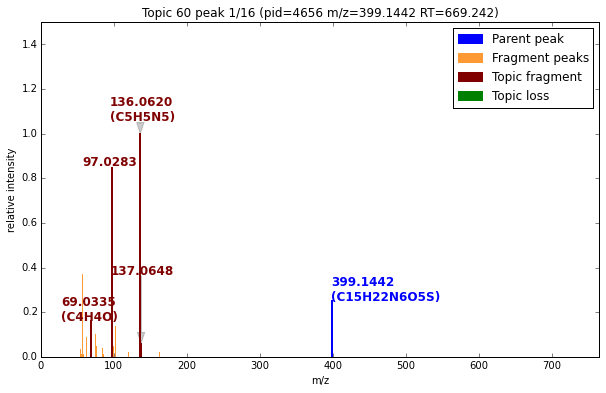

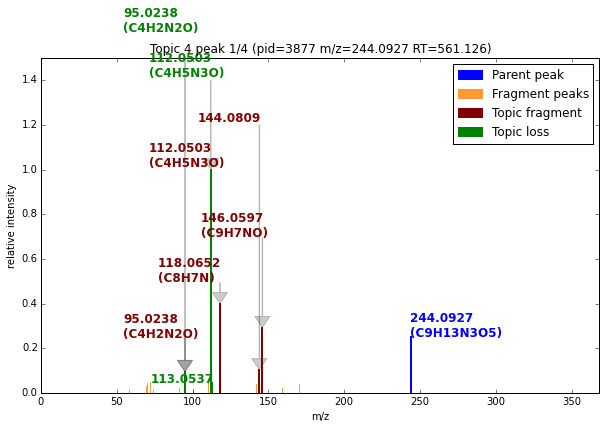

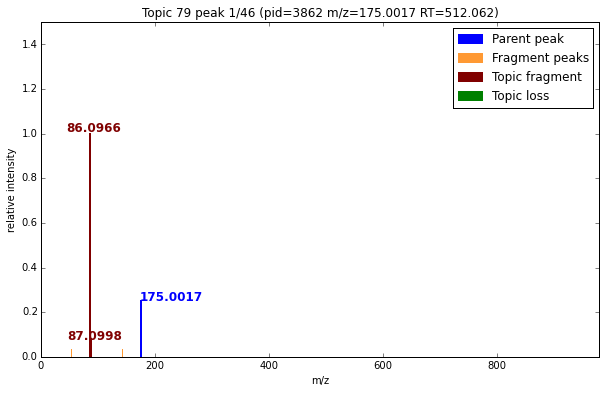

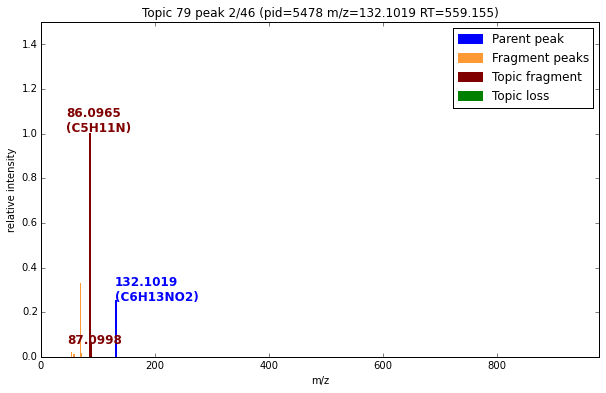

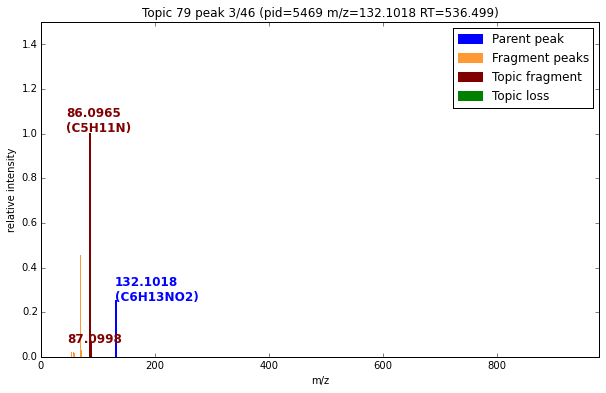

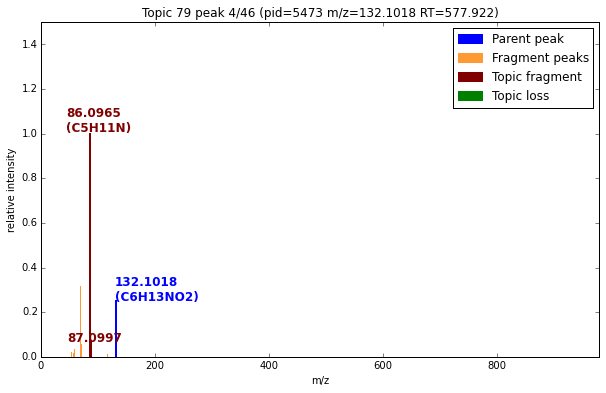

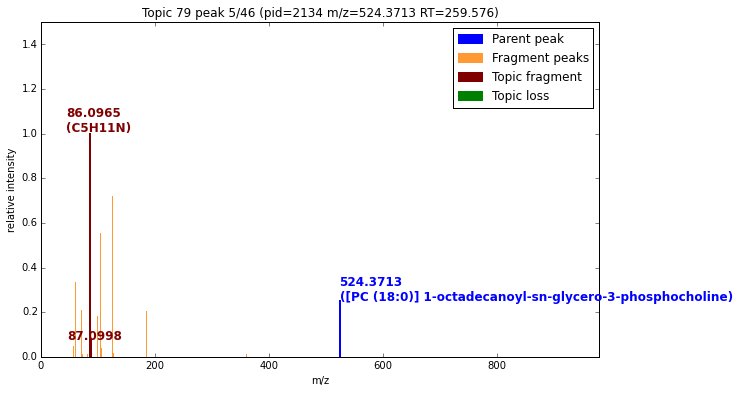

KeyboardInterrupt: 

In [23]:
interactive=True
consistency=0.0
# special_nodes = None
ms2lda.plot_lda_fragments(consistency=consistency, interactive=interactive, to_highlight=special_nodes)

In [15]:
len(ms2lda.ms1)

435